In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Загрузка DataFrame из файла
with open(r'../datasets/dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [6]:
crystal = df['Crystal']
Crystal = []

for i in crystal:
    i = i[1:]
    foo, fooo = i.split(".")
    i = foo
    #print(i)
    Crystal.append(i)

In [7]:
df['Crystal'] = Crystal
print(df['Crystal'].unique())
print(df['Stats'].unique())

['Ag' 'Al' 'Al2O3_sapphire' 'Au' 'B4C' 'Ba' 'Be' 'BeO' 'C_diamond'
 'C_graphite' 'Cr' 'Cs' 'Cu' 'Cu2MnAl' 'Fe' 'Ga' 'Gd' 'Ge' 'H2O_ice_1h'
 'He4_hcp' 'Hg' 'I2' 'K' 'Li' 'LiF' 'Mo' 'Na2Ca3Al2F14' 'Nb' 'Ni' 'Pb'
 'Pt' 'Rb' 'Si' 'Ti' 'Tl' 'UO2' 'Zn' 'Y2O3']
[1.e+07 2.e+07 5.e+07 1.e+08 2.e+08 5.e+08]


In [8]:
# Определяем целевые значения
target_crystals = ['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond',
                  'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Ge',
                  'He4_hcp', 'I2', 'K', 'Mo', 'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt',
                  'Rb', 'Si', 'Ti', 'Tl', 'UO2', 'Zn', 'Y2O3']

target_stats = [2.e+08, 5.e+08]

# Применяем фильтрацию к исходному датафрейму
df = df[
    df['Crystal'].isin(target_crystals) & 
    df['Stats'].isin(target_stats)
]
df = df.reset_index(drop= True)

In [9]:
# Загрузка DataFrame из файла
with open(r'../datasets/segmentation_maps.pkl', 'rb') as f:
    df_seg_maps = pickle.load(f)

In [9]:
tesr_samples = ['Al2O3_sapphire', 'C_graphite', 'Na2Ca3Al2F14', 'Rb', 'Si', 'UO2']

maxStats = 5.e+08
maxI = max(df['Pulce duration'].unique())

df_test = df[
    df['Crystal'].isin(tesr_samples) & 
    df['Stats'].isin([5.e+08]) & 
    df['Pulce duration'].isin([maxI])
]
df_test = df_test.reset_index(drop= True)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
df_test_matrices = np.array(df_test['Matrix'].tolist())

# Преобразование данных в тензоры PyTorch
df_test_tensor = torch.FloatTensor(df_test_matrices)
df_test_tensor = df_test_tensor.unsqueeze(1)
df_test_tensor = df_test_tensor.to(device)
print(df_test_tensor.size())

df_test_GT = df_seg_maps[
    df_seg_maps['Crystal'].isin(tesr_samples)
]
df_test_GT = df_test_GT.reset_index(drop= True)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
GT_test_matrices = np.array(df_test_GT['Mask'].tolist())

# Преобразование данных в тензоры PyTorch
GT_test_tensor = torch.FloatTensor(GT_test_matrices)
GT_test_tensor = GT_test_tensor.unsqueeze(1)
GT_test_tensor = GT_test_tensor.to(device)
print(GT_test_tensor.size())

torch.Size([6, 1, 250, 480])
torch.Size([6, 1, 250, 480])


torch.Size([1, 250, 480]) torch.Size([1, 500, 960])


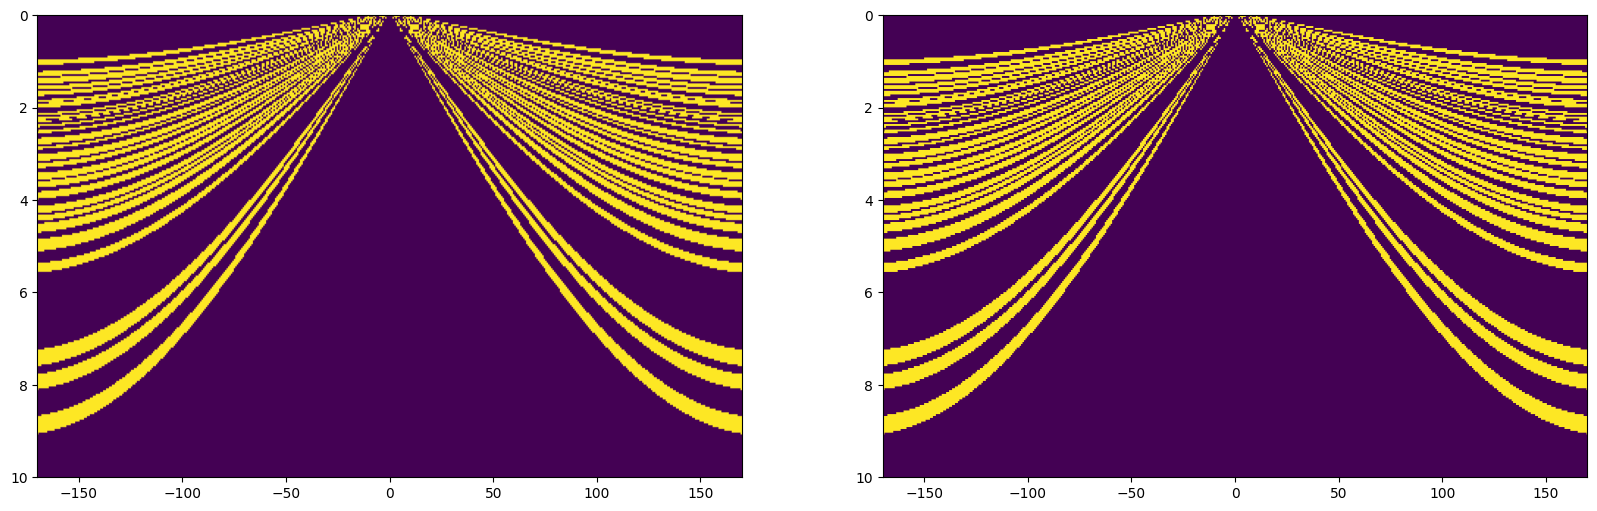

torch.Size([1, 250, 480]) torch.Size([1, 500, 960])


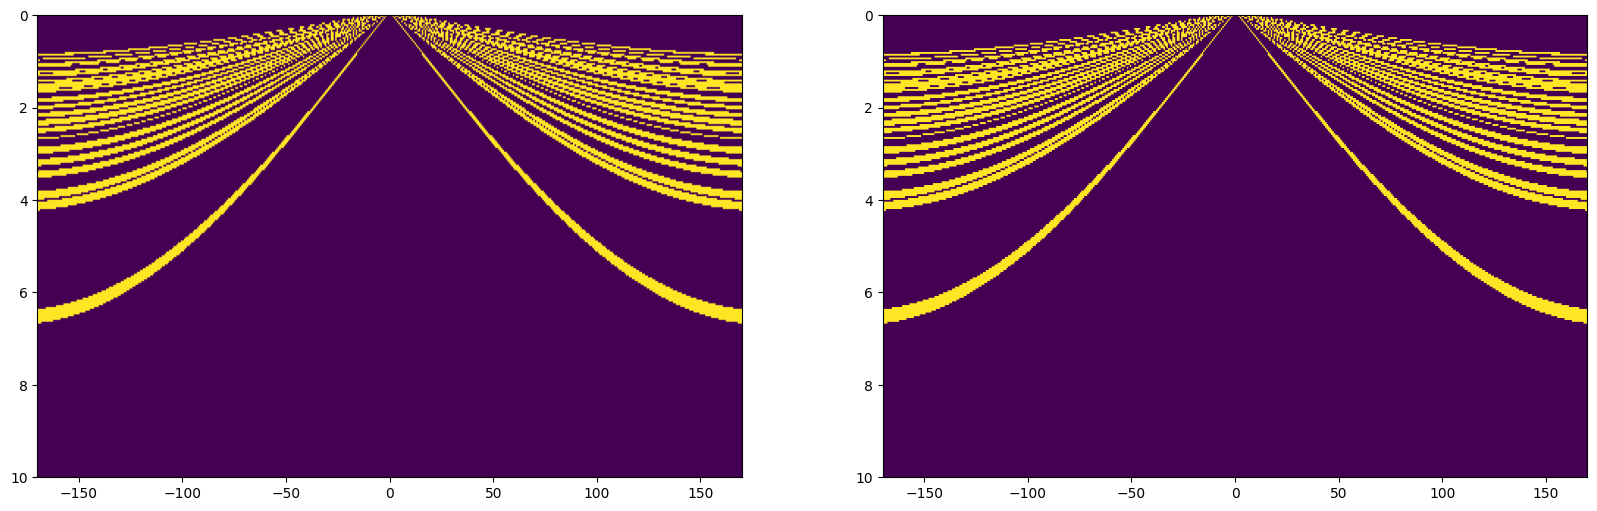

torch.Size([1, 250, 480]) torch.Size([1, 500, 960])


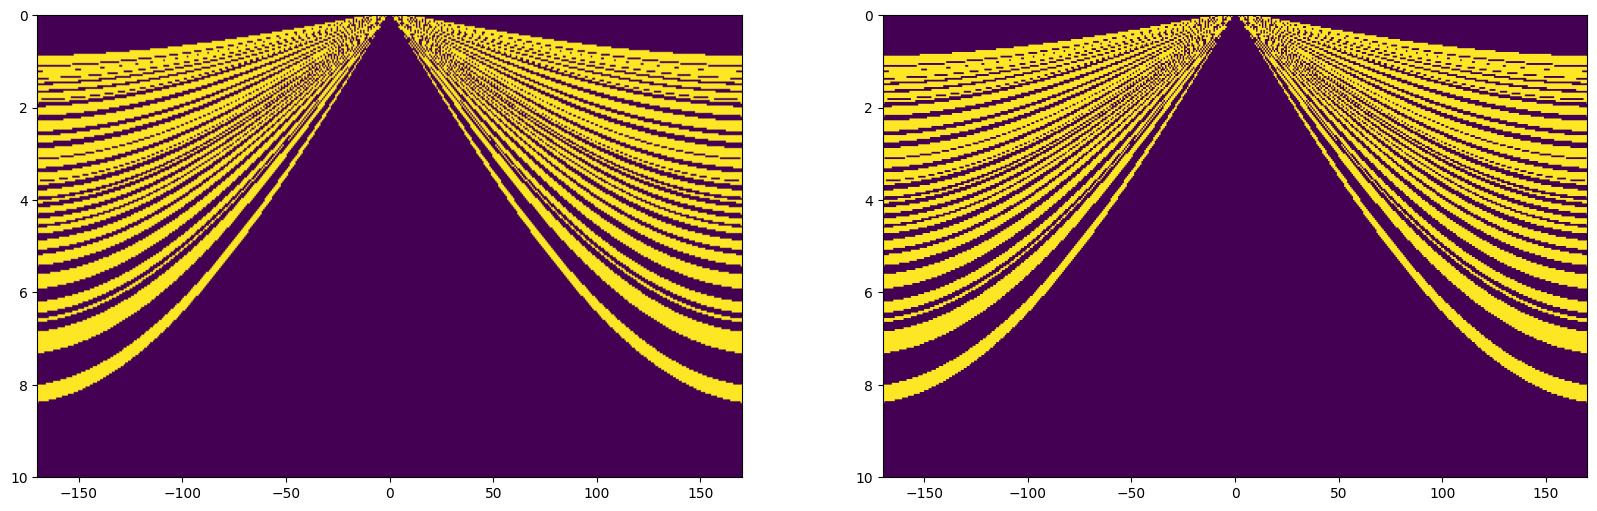

torch.Size([1, 250, 480]) torch.Size([1, 500, 960])


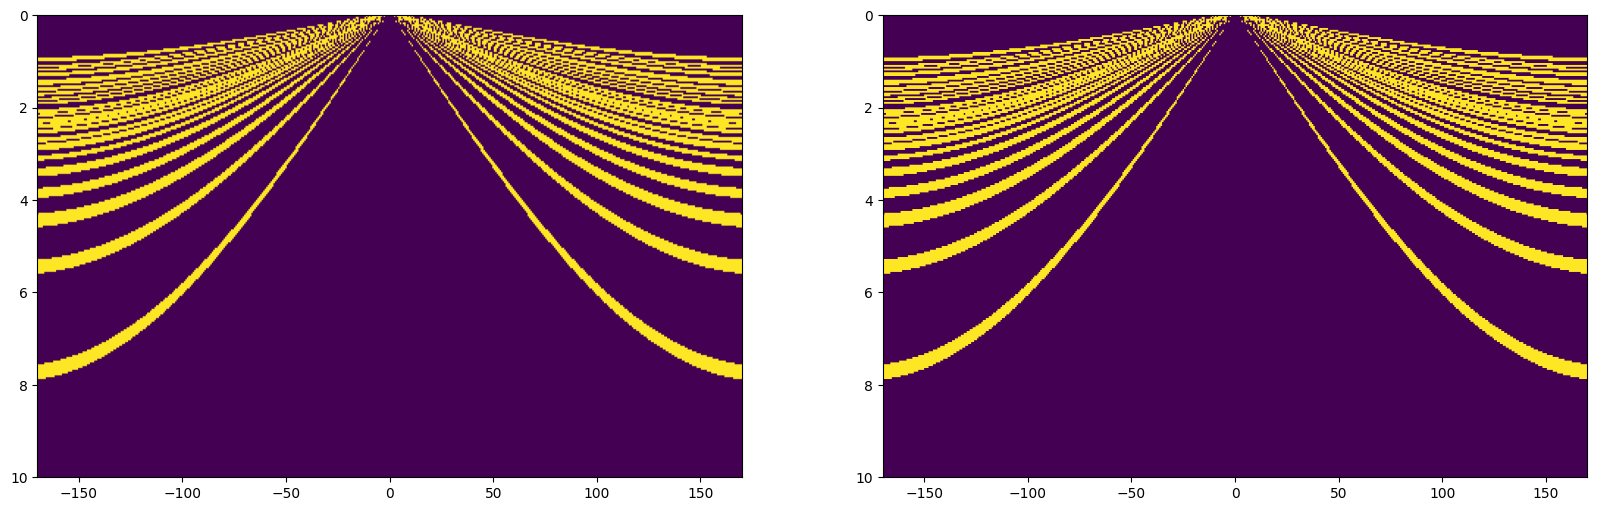

torch.Size([1, 250, 480]) torch.Size([1, 500, 960])


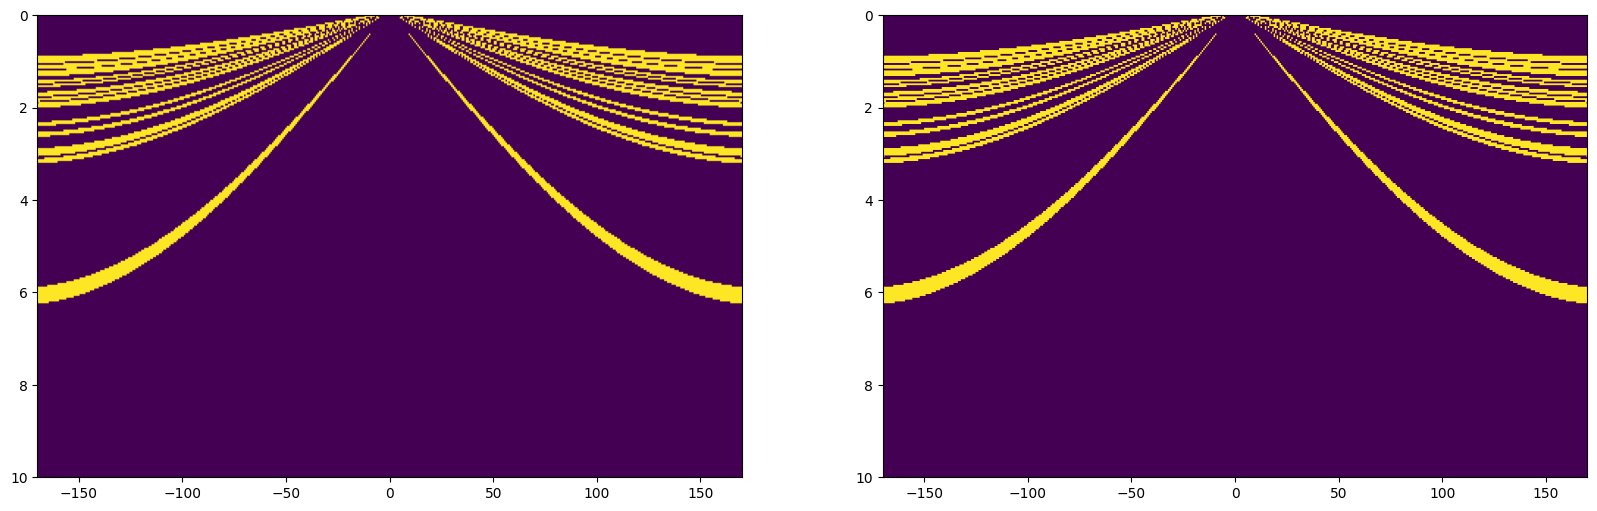

torch.Size([1, 250, 480]) torch.Size([1, 500, 960])


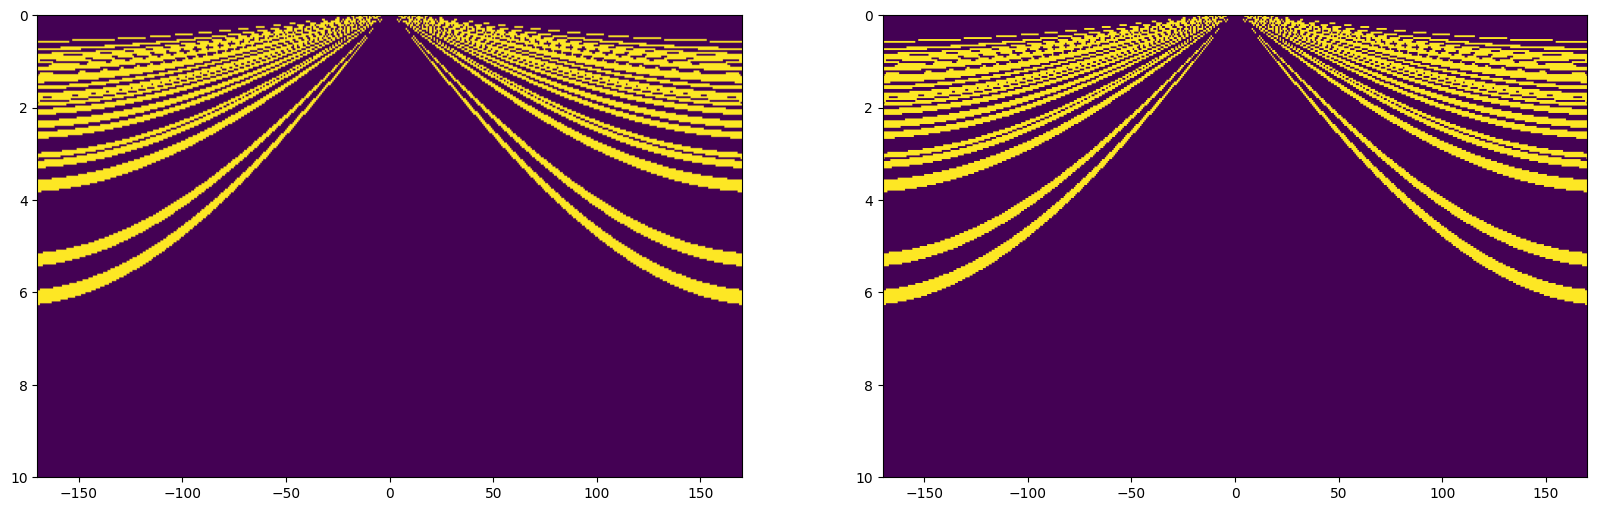

In [10]:
import torch.nn.functional as F

def upsample_binary_mask_factor(mask):
    # mask shape: [batch_size, 1, 250, 480]
    return F.interpolate(
        mask,
        scale_factor=2,  # 250*2=500, 480*2=960
        mode='nearest-exact'
    )

upscaled_GT_masks = upsample_binary_mask_factor(GT_test_tensor)

for lr, hr in zip(GT_test_tensor, upscaled_GT_masks):

    print(lr.size(), hr.size())

    # Создаем фигуру и оси
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Первый график
    ax1.imshow(lr[0].cpu().numpy(), cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))

    # Первый график
    ax2.imshow(hr[0].cpu().numpy(), cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))

    plt.show()

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class DiffractionDataset(Dataset):
    def __init__(self, df, df_seg_matrices, transform=None, crystal_list=None):
        """
        Args:
            df: DataFrame с экспериментальными данными
            df_seg_matrices: DataFrame с масками сегментации
            transform: преобразования для изображений и масок
            crystal_list: список кристаллических структур для этого датасета
        """
        self.df = df.reset_index(drop=True)
        self.df_seg_matrices = df_seg_matrices
        self.transform = transform
        
        # Если указан список кристаллов, фильтруем данные
        if crystal_list is not None:
            self.df = self.df[self.df['Crystal'].isin(crystal_list)].copy().reset_index(drop=True)
        
        # Создаем словарь для быстрого доступа к маскам
        self.mask_dict = {}
        mask_df = df_seg_matrices.set_index('Crystal')
        for crystal in mask_df.index.unique():
            mask = mask_df.loc[crystal, 'Mask']
            if isinstance(mask, pd.Series):
                mask = mask.iloc[0]  # Берем первую маску если их несколько
            self.mask_dict[crystal] = mask
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Получаем данные из df
        row = self.df.iloc[idx]
        crystal = row['Crystal']
        
        # Загружаем дифракционное изображение
        image = row['Matrix']
        
        # Получаем соответствующую маску
        mask = self.mask_dict[crystal]
        
        # Преобразуем в тензоры
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(np.array(image)).float()
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(np.array(mask)).long()
            
        # Добавляем channel dimension для изображения
        if len(image.shape) == 2:
            image = image.unsqueeze(0)  # [1, H, W]
            
        # Применяем преобразования если есть
        if self.transform:
            image, mask = self.transform(image, mask)
            
        return image, mask

# Функции для разных стратегий разделения

def split_by_crystal_stratified(df, test_size=0.2, random_state=42):
    """
    Стратегия 1: Разделяет данные так, чтобы кристаллические структуры в тесте 
    не пересекались с трейном (полное разделение по кристаллам)
    """
    # Получаем уникальные кристаллические структуры
    unique_crystals = df['Crystal'].unique()
    
    # Разделяем кристаллы на train и test
    train_crystals, test_crystals = train_test_split(
        unique_crystals, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True
    )
    
    # Создаем train и test датафреймы
    train_df = df[df['Crystal'].isin(train_crystals)].copy()
    test_df = df[df['Crystal'].isin(test_crystals)].copy()
    
    print(f"Стратегия: Разделение по кристаллам (без пересечений)")
    print(f"Train crystals ({len(train_crystals)}): {train_crystals}")
    print(f"Test crystals ({len(test_crystals)}): {test_crystals}")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    return train_df, test_df, train_crystals, test_crystals

def split_simple_stratified(df, test_size=0.2, random_state=42, stratify_by_crystal=True):
    """
    Стратегия 2: Простое разделение, где каждый кристалл может быть и в трейне и в тесте
    
    Args:
        stratify_by_crystal: если True, стратифицируем по кристаллам
    """
    if stratify_by_crystal:
        # Стратифицируем по кристаллам для сбалансированного разделения
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            stratify=df['Crystal'],  # Стратификация по кристаллам
            shuffle=True
        )
    else:
        # Простое случайное разделение
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )
    
    # Получаем уникальные кристаллы в каждой выборке
    train_crystals = train_df['Crystal'].unique()
    test_crystals = test_df['Crystal'].unique()
    
    # Находим пересечение кристаллов
    intersection = set(train_crystals) & set(test_crystals)
    
    print(f"Стратегия: Простое разделение (с пересечениями)")
    print(f"Train crystals ({len(train_crystals)}): {len(train_crystals)} уникальных")
    print(f"Test crystals ({len(test_crystals)}): {len(test_crystals)} уникальных")
    print(f"Пересечение кристаллов: {len(intersection)} общих кристаллов")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Для совместимости возвращаем train_crystals и test_crystals
    return train_df, test_df, train_crystals, test_crystals

def split_data(df, strategy='crystal', test_size=0.2, random_state=42, **kwargs):
    """
    Основная функция разделения данных с выбором стратегии
    
    Args:
        df: DataFrame с данными
        strategy: стратегия разделения
            - 'crystal': разделение по кристаллам (без пересечений)
            - 'simple': простое разделение (с пересечениями)
        test_size: доля тестовой выборки
        random_state: seed для воспроизводимости
        **kwargs: дополнительные аргументы для стратегий
    
    Returns:
        train_df, test_df, train_crystals, test_crystals
    """
    if strategy == 'crystal':
        return split_by_crystal_stratified(df, test_size, random_state)
    elif strategy == 'simple':
        stratify_by_crystal = kwargs.get('stratify_by_crystal', True)
        return split_simple_stratified(df, test_size, random_state, stratify_by_crystal)
    else:
        raise ValueError(f"Неизвестная стратегия: {strategy}. Используйте 'crystal' или 'simple'")

In [11]:
def create_dataloaders(df, df_seg_matrices, batch_size=32, test_size=0.2, 
                       shuffle=True, num_workers=0, random_state=42,
                       split_strategy='crystal', **split_kwargs):
    """
    Создает DataLoader'ы с выбором стратегии разделения
    
    Args:
        split_strategy: стратегия разделения
            - 'crystal': разделение по кристаллам (без пересечений)
            - 'simple': простое разделение (с пересечениями)
        split_kwargs: дополнительные аргументы для стратегии разделения
    """
    print(f"\n{'='*60}")
    print(f"Создание DataLoader'ов со стратегией: {split_strategy}")
    print(f"{'='*60}")
    
    # Разделяем данные согласно выбранной стратегии
    train_df, test_df, train_crystals, test_crystals = split_data(
        df, 
        strategy=split_strategy,
        test_size=test_size, 
        random_state=random_state,
        **split_kwargs
    )
    
    # Создаем датасеты
    train_dataset = DiffractionDataset(
        train_df, 
        df_seg_matrices, 
        transform=None,
        crystal_list=None  # Не фильтруем по crystal_list для простого разделения
    )
    
    test_dataset = DiffractionDataset(
        test_df, 
        df_seg_matrices, 
        transform=None,
        crystal_list=None
    )
    
    # Определяем параметры для DataLoader
    loader_kwargs = {
        'batch_size': batch_size,
        'shuffle': shuffle,
        'pin_memory': True if torch.cuda.is_available() else False
    }
    
    # Добавляем num_workers только если он > 0
    if num_workers > 0:
        loader_kwargs['num_workers'] = num_workers
        loader_kwargs['persistent_workers'] = True if num_workers > 0 else False
    
    # Создаем DataLoader'ы
    train_loader = DataLoader(train_dataset, **loader_kwargs)
    
    # Для test_loader отключаем shuffle
    loader_kwargs['shuffle'] = False
    test_loader = DataLoader(test_dataset, **loader_kwargs)
    
    return train_loader, test_loader, train_crystals, test_crystals

In [12]:
# Создаем DataLoader'ы
train_loader, test_loader, train_crystals, test_crystals = create_dataloaders(
    df=df,
    df_seg_matrices=df_seg_maps,
    batch_size=3,
    test_size=0.2,
    shuffle=True,
    random_state=42,
    split_strategy='simple' # 'crystal' 'simple'
)

# Проверяем размерность батча
for diffractions, masks in train_loader:
    print(f"Images shape: {diffractions.shape}")  # [batch_size, 1, H, W]
    print(f"Masks shape: {masks.shape}")    # [batch_size, H, W]

    break


Создание DataLoader'ов со стратегией: simple
Стратегия: Простое разделение (с пересечениями)
Train crystals (30): 30 уникальных
Test crystals (30): 30 уникальных
Пересечение кристаллов: 30 общих кристаллов
Train samples: 960
Test samples: 240
Images shape: torch.Size([3, 1, 250, 480])
Masks shape: torch.Size([3, 250, 480])


In [13]:
def load_swinunet_weights_into_swinwnet(swinwnet, swinunet_segmentator_ckpt_path, swinunet_upscaler_ckpt_path, device="cpu"):
    old_state_segmentator = torch.load(swinunet_segmentator_ckpt_path, map_location=device)
    old_state_upscaler = torch.load(swinunet_upscaler_ckpt_path, map_location=device)
    new_state = {}

    for k, v in old_state_segmentator.items():

        # 1. PatchEmbed (имя совпадает)
        if k.startswith("encoder.patch_embed."):
            new_key = k.replace("encoder.patch_embed.", "patch_embed.")
            new_state[new_key] = v

        # 2. Encoder → Segmentator Encoder
        elif k.startswith("encoder."):
            new_key = k.replace("encoder.", "segmentator_encoder.")
            new_state[new_key] = v

        # 3. Bottleneck → Segmentator Bottleneck
        elif k.startswith("bottleneck."):
            new_key = k.replace("bottleneck.", "segmentator_bottleneck.")
            new_state[new_key] = v

        # 4. Decoder → Segmentator Decoder
        elif k.startswith("decoder."):
            new_key = k.replace("decoder.", "segmentator_decoder.")
            new_state[new_key] = v

        # 5. Head → Segmentator Head
        elif k.startswith("head."):
            # ⬇️ ВАЖНО: меняем имя внутреннего модуля
            new_key = k.replace("head.", "segmentator_head.")
            new_key = new_key.replace(
                "seg_segmentator_head",
                "seg_head"
            )
            new_state[new_key] = v
    for k, v in old_state_upscaler.items():

        # 1. Encoder → Segmentator Encoder
        if k.startswith("encoder."):
            new_key = k.replace("encoder.", "upscaler_encoder.")
            new_state[new_key] = v

        # 2. Bottleneck → Segmentator Bottleneck
        elif k.startswith("bottleneck."):
            new_key = k.replace("bottleneck.", "upscaler_bottleneck.")
            new_state[new_key] = v

        # 3. Decoder → Segmentator Decoder
        elif k.startswith("decoder."):
            new_key = k.replace("decoder.", "upscaler_decoder.")
            new_state[new_key] = v

        # 4. Head → Segmentator Head
        elif k.startswith("head."):
            new_key = k.replace("head.", "upscaler_head.")
            new_state[new_key] = v

        # всё остальное игнорируем

    missing, unexpected = swinwnet.load_state_dict(new_state, strict=False)

    print("✅ Weights loaded from SwinUNet → SwinWNet")
    print("Missing keys:", missing)
    print("Unexpected keys:", unexpected)

In [14]:
old_state_segmentator = torch.load("../models/SwinUnet_binary_segmentation_diffraction.pth", map_location=device)
for k, v in old_state_segmentator.items():
    print(k)
    
old_state_upscaler = torch.load("../models/SwinUnetSR_upscaler_for_segmented_diffraction.pth", map_location=device)
for k, v in old_state_upscaler.items():
        print(k)

encoder.patch_embed.proj.weight
encoder.patch_embed.proj.bias
encoder.patch_embed.norm.weight
encoder.patch_embed.norm.bias
encoder.layers.0.blocks.0.norm1.weight
encoder.layers.0.blocks.0.norm1.bias
encoder.layers.0.blocks.0.attn.relative_position_bias_table
encoder.layers.0.blocks.0.attn.relative_position_index
encoder.layers.0.blocks.0.attn.qkv.weight
encoder.layers.0.blocks.0.attn.qkv.bias
encoder.layers.0.blocks.0.attn.proj.weight
encoder.layers.0.blocks.0.attn.proj.bias
encoder.layers.0.blocks.0.norm2.weight
encoder.layers.0.blocks.0.norm2.bias
encoder.layers.0.blocks.0.mlp.0.weight
encoder.layers.0.blocks.0.mlp.0.bias
encoder.layers.0.blocks.0.mlp.3.weight
encoder.layers.0.blocks.0.mlp.3.bias
encoder.layers.0.blocks.1.norm1.weight
encoder.layers.0.blocks.1.norm1.bias
encoder.layers.0.blocks.1.attn.relative_position_bias_table
encoder.layers.0.blocks.1.attn.relative_position_index
encoder.layers.0.blocks.1.attn.qkv.weight
encoder.layers.0.blocks.1.attn.qkv.bias
encoder.layers.0.b

In [15]:
import torch
from SwinUNet import SwinWNet

test1 = torch.randn(2, 1, 250, 480).to(device)
test2 = torch.randn(2, 1, 125, 240).to(device)

model = SwinWNet(patch_size=2, in_chans=1, embed_dim=48, depths=[2, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=5, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.).to(device)

load_swinunet_weights_into_swinwnet(model, 
                                    swinunet_segmentator_ckpt_path="../models/SwinUnet_binary_segmentation_diffraction.pth", 
                                    swinunet_upscaler_ckpt_path="../models/SwinUnetSR_upscaler_for_segmented_diffraction.pth", 
                                    device=device)

# i = 1
# with torch.no_grad():
#     if i == 0:
#         seg, skips_seg = model.segment_1(test1)
#         sr_out, _ = model.upscale(test2, skips_seg)

#         print(seg.size())
#         print(sr_out.size())

#     else:
#         seg, skips_seg = model.segment_1(test1)
#         sr_out, skips_sr = model.upscale(seg, skips_seg)
#         seg_high, _ = model.segment_2(sr_out, skips_sr)

#         print(seg.size())
#         print(sr_out.size())
#         print(seg_high.size())

✅ Weights loaded from SwinUNet → SwinWNet
Missing keys: ['ca_seg_to_sr.blocks.0.gamma', 'ca_seg_to_sr.blocks.0.norm_q.weight', 'ca_seg_to_sr.blocks.0.norm_q.bias', 'ca_seg_to_sr.blocks.0.norm_kv.weight', 'ca_seg_to_sr.blocks.0.norm_kv.bias', 'ca_seg_to_sr.blocks.0.attn.in_proj_weight', 'ca_seg_to_sr.blocks.0.attn.in_proj_bias', 'ca_seg_to_sr.blocks.0.attn.out_proj.weight', 'ca_seg_to_sr.blocks.0.attn.out_proj.bias', 'ca_seg_to_sr.blocks.1.gamma', 'ca_seg_to_sr.blocks.1.norm_q.weight', 'ca_seg_to_sr.blocks.1.norm_q.bias', 'ca_seg_to_sr.blocks.1.norm_kv.weight', 'ca_seg_to_sr.blocks.1.norm_kv.bias', 'ca_seg_to_sr.blocks.1.attn.in_proj_weight', 'ca_seg_to_sr.blocks.1.attn.in_proj_bias', 'ca_seg_to_sr.blocks.1.attn.out_proj.weight', 'ca_seg_to_sr.blocks.1.attn.out_proj.bias', 'ca_sr_to_seg.blocks.0.gamma', 'ca_sr_to_seg.blocks.0.norm_q.weight', 'ca_sr_to_seg.blocks.0.norm_q.bias', 'ca_sr_to_seg.blocks.0.norm_kv.weight', 'ca_sr_to_seg.blocks.0.norm_kv.bias', 'ca_sr_to_seg.blocks.0.attn.in_p

In [16]:
def normalize_piecewise(x, threshold=0.01, eps=1e-6):
    """
    x: [B, 1, H, W] tensor after convolution
    returns:
        x_norm: normalized tensor
        params: dict with all values needed for denormalization
    """
    # per-image min/max
    x_min = x.amin(dim=(2, 3), keepdim=True)
    x_max = x.amax(dim=(2, 3), keepdim=True)

    # scale to [0, 1]
    x01 = (x - x_min) / (x_max - x_min + eps)

    # piecewise: weak intensities linear, strong -> logarithmic compression
    mask = x01 > threshold

    # log transform only strong pixels
    x_strong = torch.log1p(x01) / torch.log1p(torch.tensor(1.0))

    # combine back
    x_norm = torch.where(mask, x_strong, x01)

    params = {
        'x_min': x_min,
        'x_max': x_max,
        'threshold': threshold
    }

    return x_norm, params

def denormalize_piecewise(x_norm, params, eps=1e-6):
    """
    x_norm: normalized output of upscaler
    params: dict returned by normalize_piecewise
    """
    x_min = params['x_min']
    x_max = params['x_max']
    threshold = params['threshold']

    # Split strong and weak regions
    mask = x_norm > threshold

    # inverse log for strong pixels
    x_strong = torch.expm1(x_norm)

    # combine back
    x01 = torch.where(mask, x_strong, x_norm)

    # rescale back to original dynamic range
    x = x01 * (x_max - x_min + eps) + x_min
    return x


In [18]:
import torch
import torch.nn.functional as F
from torch import nn
import os, sys


# ---- Dice Loss ----
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, pred_logits, target):
        # pred_logits: (N,1,H,W) logits
        pred = torch.sigmoid(pred_logits)
        target = target.float()
        intersection = (pred * target).sum(dim=[1,2,3])
        union = pred.sum(dim=[1,2,3]) + target.sum(dim=[1,2,3])
        dice = (2. * intersection + self.eps) / (union + self.eps)
        return 1. - dice.mean()

# ---- Tversky / Focal-Tversky ----
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = eps
    def forward(self, pred_logits, target):
        pred = torch.sigmoid(pred_logits)
        target = target.float()
        TP = (pred * target).sum(dim=[1,2,3])
        FP = (pred * (1-target)).sum(dim=[1,2,3])
        FN = ((1-pred) * target).sum(dim=[1,2,3])
        tversky = (TP + self.eps) / (TP + self.alpha*FP + self.beta*FN + self.eps)
        return 1.0 - tversky.mean()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, gamma=0.75):
        super().__init__()
        self.tversky = TverskyLoss(alpha, beta)
        self.gamma = gamma
    def forward(self, pred_logits, target):
        t = 1.0 - self.tversky(pred_logits, target)  # tversky score
        return (1 - t**self.gamma)

# ---- Focal BCE ----
class FocalBCE(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, target):
        bce = F.binary_cross_entropy_with_logits(logits, target.float(), reduction='none')
        pred_prob = torch.sigmoid(logits)
        p_t = target * pred_prob + (1-target) * (1-pred_prob)
        mod = (1 - p_t) ** self.gamma
        loss = self.alpha * mod * bce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# ---- Combined loss example ----
class CombinedLoss(nn.Module):
    def __init__(self, w_bce=1.0, w_dice=1.0, w_boundary=1.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.w_bce = w_bce
        self.w_dice = w_dice
        self.w_boundary = w_boundary
    def forward(self, logits, target, boundary_weight_map=None):
        # boundary_weight_map: same shape as target, optional per-pixel weights
        bce_loss = F.binary_cross_entropy_with_logits(logits, target.float(), reduction='none')
        if boundary_weight_map is not None:
            bce_loss = (bce_loss * boundary_weight_map).mean()
        else:
            bce_loss = bce_loss.mean()
        dice_loss = self.dice(logits, target)
        # Optionally add boundary/surface loss term here (see below)
        loss = self.w_bce * bce_loss + self.w_dice * dice_loss
        return loss

# Добавляем путь к родительской директории
current_dir = os.path.dirname(os.path.abspath('.'))
sys.path.append(current_dir)

# ДОБАВЛЯЕМ ТАКЖЕ ПУТЬ К ПАПКЕ SUPPORT_FILES
support_files_path = os.path.join(current_dir, 'support_files')
sys.path.append(support_files_path)

from Peak_loss import DiffractionPipeline

# ---------------- Losses (same as earlier + small improvements) ----------------
def l1_loss(pred, target):
    return F.l1_loss(pred, target)

fixed_centers_hr = np.linspace(0.05318052, 7.49710258, 1241)
fixed_centers_lr = np.linspace(0.0546658, 7.49180085, 832)

pipe = DiffractionPipeline(
    fixed_centers_pred=fixed_centers_hr,
    fixed_centers_true=fixed_centers_lr,
    device=device
)

In [19]:
from tqdm import tqdm
import torch.nn.functional as F

def upsample_binary_mask_factor(mask):
    # mask shape: [batch_size, 1, 250, 480]
    return F.interpolate(
        mask,
        scale_factor=2,  # 250*2=500, 480*2=960
        mode='nearest-exact'
    )

lambda_phys=1.0
loss_fn_segmentator = CombinedLoss(w_bce=1.0, w_dice=1.0)

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        mu = 100
        sigma = 0.2*mu
        
        # Создаем шум на том же устройстве
        noise = torch.randn_like(images, device=device) * sigma + mu
        images = images + noise

        is_even = (batch_idx % 2 == 0)

        with torch.cuda.amp.autocast():
            if is_even:
                # ===== EVEN BATCH =====
                seg, skips_seg = model.segment_1(images)
                loss_seg = loss_fn_segmentator(seg, masks)
                print(f'loss_seg {loss_seg}')

                # prepare data for SR
                seg = torch.sigmoid(seg)
                images = seg * images

                lr = F.interpolate(
                    images, 
                    scale_factor=0.5, 
                    mode='bilinear', 
                    align_corners=False
                )  # размер: [32, 1, 125, 240]

                norm_lr, _ = normalize_piecewise(lr)
                norm_hr, params_hr = normalize_piecewise(images)

                sr_out, _ = model.upscale(norm_lr.to(device), skips_seg)

                rec = l1_loss(sr_out, norm_hr.to(device))
                denorm_rec = denormalize_piecewise(sr_out, params_hr)

                loss_peaks = pipe(
                    batch_pred_2d=denorm_rec,     # предсказанная 2D дифракция
                    batch_true_2d=lr,     # ground-truth 2D
                    peak_params_pred={"scale": True},
                    peak_params_true={"scale": False},
                    tol=0.05
                )
                loss_upscaler = torch.where(
                    rec >= 0.06,
                    rec,
                    rec + lambda_phys * loss_peaks
                )

                print(f'rec {rec} loss_peaks {loss_peaks}')

                loss = loss_seg + loss_upscaler

            else:
                # ===== ODD BATCH =====
                seg, skips_seg = model.segment_1(images)
                loss_low = loss_fn_segmentator(seg, masks)

                print(f'loss_low {loss_low}')

                # prepare data for SR
                seg = torch.sigmoid(seg)
                images = seg * images

                norm_hr, params_hr = normalize_piecewise(images)
                # SR @ full scale
                sr_out, skips_sr = model.upscale(norm_hr.to(device), skips_seg)
                denorm_pred = denormalize_piecewise(sr_out, params_hr)

                # segmentation @ 2H
                seg_high, _ = model.segment_2(denorm_pred, skips_sr)

                masks = masks.float()  # Конвертируем в float
                masks = upsample_binary_mask_factor(masks)
                masks = masks.long()  # Возвращаем в long если нужно
                loss_high = loss_fn_segmentator(seg_high, masks)

                print(f'loss_high {loss_high}')

        print('-----------------------------------------------------------')


loss_seg 0.13480721414089203
rec 0.007939843460917473 loss_peaks 2.631686210632324
-----------------------------------------------------------
loss_low 0.33240288496017456
loss_high 1.29402494430542
-----------------------------------------------------------
loss_seg 0.19284021854400635
rec 0.013121072202920914 loss_peaks 9.311007499694824
-----------------------------------------------------------
loss_low 0.16063083708286285
loss_high 0.9878804683685303
-----------------------------------------------------------
loss_seg 0.12903881072998047
rec 0.008339145220816135 loss_peaks 1.122380256652832
-----------------------------------------------------------
loss_low 0.14802467823028564
loss_high 1.11079740524292
-----------------------------------------------------------
loss_seg 0.12591552734375
rec 0.011357645504176617 loss_peaks 9.664894104003906
-----------------------------------------------------------
loss_low 0.23460492491722107
loss_high 1.5603786706924438
-----------------------

KeyboardInterrupt: 

In [19]:
from tqdm import tqdm
import torch.nn.functional as F

def upsample_binary_mask_factor(mask):
    # mask shape: [batch_size, 1, 250, 480]
    return F.interpolate(
        mask,
        scale_factor=2,  # 250*2=500, 480*2=960
        mode='nearest-exact'
    )

def train_one_epoch(
        model,
        loss_fn_segmentator,
        train_loader, 
        val_loader, 
        optimizer, 
        scheduler, 
        device, 
        scaler,
        epoch_num, 
        num_epochs,
        lambda_phys=1.0):
        
    model.train()

    total_loss_train = 0.0
    total_loss_segmrntation_lr_train = 0.0
    total_loss_l1_train = 0.0
    total_peaks_loss_train = 0.0
    total_loss_segmrntation_hr_train = 0.0

    total_loss_test = 0.0
    total_loss_segmrntation_lr_test = 0.0
    total_loss_l1_test = 0.0
    total_peaks_loss_test = 0.0
    total_loss_segmrntation_hr_test = 0.0

    for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch_num+1} Train", leave=False)):
        optimizer.zero_grad(set_to_none=True)

        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        mu = 100
        sigma = 0.2*mu
        
        # Создаем шум на том же устройстве
        noise = torch.randn_like(images, device=device) * sigma + mu
        images = images + noise

        is_even = (batch_idx % 2 == 0)

        with torch.cuda.amp.autocast():
            if is_even:
                # ===== EVEN BATCH =====
                seg, skips_seg = model.segment_1(images)
                loss_seg = loss_fn_segmentator(seg, masks)

                # prepare data for SR
                seg = torch.sigmoid(seg)
                images = seg * images

                lr = F.interpolate(
                    images, 
                    scale_factor=0.5, 
                    mode='bilinear', 
                    align_corners=False
                )  # размер: [32, 1, 125, 240]

                norm_lr, _ = normalize_piecewise(lr)
                norm_hr, params_hr = normalize_piecewise(images)

                sr_out, _ = model.upscale(norm_lr.to(device), skips_seg)

                rec = l1_loss(sr_out, norm_hr.to(device))
                denorm_rec = denormalize_piecewise(sr_out, params_hr)

                loss_peaks = pipe(
                    batch_pred_2d=denorm_rec,     # предсказанная 2D дифракция
                    batch_true_2d=lr,     # ground-truth 2D
                    peak_params_pred={"scale": True},
                    peak_params_true={"scale": False},
                    tol=0.05
                )
                loss_upscaler = torch.where(
                    rec >= 0.06,
                    rec,
                    rec + lambda_phys * loss_peaks
                )

                loss = loss_seg + loss_upscaler


                total_loss_train += loss.item()
                total_loss_segmrntation_lr_train += loss_seg.item()
                total_loss_l1_train += rec.item()
                total_peaks_loss_train += loss_peaks.item()

            else:
                # ===== ODD BATCH =====
                seg, skips_seg = model.segment_1(images)
                loss_low = loss_fn_segmentator(seg, masks)

                # prepare data for SR
                seg = torch.sigmoid(seg)
                images = seg * images

                norm_hr, params_hr = normalize_piecewise(images)
                # SR @ full scale
                sr_out, skips_sr = model.upscale(norm_hr.to(device), skips_seg)
                denorm_pred = denormalize_piecewise(sr_out, params_hr)

                # segmentation @ 2H
                seg_high, _ = model.segment_2(denorm_pred, skips_sr)

                masks = masks.float()  # Конвертируем в float
                masks = upsample_binary_mask_factor(masks)
                masks = masks.long()  # Возвращаем в long если нужно
                loss_high = loss_fn_segmentator(seg_high, masks)

                loss = loss_low + loss_high

                total_loss_train += loss.item()
                total_loss_segmrntation_lr_train += loss_low.item()
                total_loss_segmrntation_hr_train += loss_high.item()


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


    model.eval()

    with torch.no_grad():  # <--- ДОБАВИТЬ ЭТО
        for batch_idx, (images, masks) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch_num+1} Val", leave=False)):

            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(images, device=device) * sigma + mu
            images = images + noise

            is_even = (batch_idx % 2 == 0)

            with torch.cuda.amp.autocast():
                if is_even:
                    # ===== EVEN BATCH =====
                    seg, skips_seg = model.segment_1(images)
                    loss_seg = loss_fn_segmentator(seg, masks)

                    # prepare data for SR
                    seg = torch.sigmoid(seg)
                    images = seg * images

                    lr = F.interpolate(
                        images, 
                        scale_factor=0.5, 
                        mode='bilinear', 
                        align_corners=False
                    )  # размер: [32, 1, 125, 240]

                    norm_lr, _ = normalize_piecewise(lr)
                    norm_hr, params_hr = normalize_piecewise(images)

                    sr_out, _ = model.upscale(norm_lr.to(device), skips_seg)

                    rec = l1_loss(sr_out, norm_hr.to(device))
                    denorm_rec = denormalize_piecewise(sr_out, params_hr)

                    loss_peaks = pipe(
                        batch_pred_2d=denorm_rec,     # предсказанная 2D дифракция
                        batch_true_2d=lr,     # ground-truth 2D
                        peak_params_pred={"scale": True},
                        peak_params_true={"scale": False},
                        tol=0.05
                    )
                    if rec.item() >= 0.06:
                        loss_upscaler = rec
                    else:
                        loss_upscaler = rec + lambda_phys * loss_peaks

                    loss = loss_seg + loss_upscaler


                    total_loss_test += loss.item()
                    total_loss_segmrntation_lr_test += loss_seg.item()
                    total_loss_l1_test += rec.item()
                    total_peaks_loss_test += loss_peaks.item()

                else:
                    # ===== ODD BATCH =====
                    seg, skips_seg = model.segment_1(images)
                    loss_low = loss_fn_segmentator(seg, masks)

                    # prepare data for SR
                    seg = torch.sigmoid(seg)
                    images = seg * images

                    norm_hr, params_hr = normalize_piecewise(images)
                    # SR @ full scale
                    sr_out, skips_sr = model.upscale(norm_hr.to(device), skips_seg)
                    denorm_pred = denormalize_piecewise(sr_out, params_hr)

                    # segmentation @ 2H
                    seg_high, _ = model.segment_2(denorm_pred, skips_sr)

                    masks = masks.float()  # Конвертируем в float
                    masks = upsample_binary_mask_factor(masks)
                    masks = masks.long()  # Возвращаем в long если нужно
                    loss_high = loss_fn_segmentator(seg_high, masks)

                    loss = loss_low + loss_high

                    total_loss_test += loss.item()
                    total_loss_segmrntation_lr_test += loss_low.item()
                    total_loss_segmrntation_hr_test += loss_high.item()


    # Обновление планировщика
    scheduler.step()

    # Вывод информации об эпохе
    print(f"Epoch [{epoch_num+1}/{num_epochs}] "
          f'Average train loss: {total_loss_train / len(train_loader):.4f} '
          f'Segmentation low res train loss: {total_loss_segmrntation_lr_train / len(train_loader):.4f} '  
          f'Recon train loss: {total_loss_l1_train / len(train_loader):.4f} '
          f'Peak train loss: {total_peaks_loss_train / len(train_loader):.4f} '
          f'Segmentation high res train loss: {total_loss_segmrntation_hr_train / len(train_loader):.4f} ' 
          f'Average test loss: {total_loss_test / len(val_loader):.4f} '
          f'Segmentation low res test loss: {total_loss_segmrntation_lr_test / len(val_loader):.4f} ' 
          f'Recon test loss: {total_loss_l1_test / len(val_loader):.4f} '
          f'Peak test loss: {total_peaks_loss_test / len(val_loader):.4f} '
          f'Segmentation high res test loss: {total_loss_segmrntation_hr_test / len(val_loader):.4f} '
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")


In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import math

# Планировщик с косинусным затуханием и warmup
def get_scheduler(optimizer, warmup_epochs, total_epochs, base_lr):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Linear warmup
            return (epoch + 1) / warmup_epochs
        else:
            # Cosine annealing
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Попробуйте такую конфигурацию:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,  # Чуть выше начальный LR
    betas=(0.9, 0.999),
    eps=1e-8,  # Стандартное значение
    weight_decay=1e-4  # Увеличьте weight decay для лучшей регуляризации
)

# Использование:
scheduler = get_scheduler(optimizer, warmup_epochs=10, total_epochs=100, base_lr=1e-4)

In [48]:
import torch
from torch.cuda.amp import GradScaler

# Инициализация скалера только если используется FP16
scaler = GradScaler()

# Главный цикл обучения
num_epochs = 100
for epoch in range(num_epochs):
    train_one_epoch(
        model=model,
        loss_fn_segmentator=CombinedLoss(w_bce=1.0, w_dice=1.0),
        train_loader=train_loader,
        val_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        scaler=scaler,
        epoch_num=epoch,
        num_epochs=num_epochs,
        lambda_phys=1.0)

Epoch [1/100] Average train loss: 3.5104 Segmentation low res train loss: 0.2349 Recon train loss: 0.0062 Peak train loss: 3.1532 Segmentation high res train loss: 0.1161 Average test loss: 4.4092 Segmentation low res test loss: 0.2512 Recon test loss: 0.0063 Peak test loss: 4.0288 Segmentation high res test loss: 0.1228 LR: 2.00e-04


Epoch [2/100] Average train loss: 3.2335 Segmentation low res train loss: 0.2398 Recon train loss: 0.0063 Peak train loss: 2.8702 Segmentation high res train loss: 0.1172 Average test loss: 3.0984 Segmentation low res test loss: 0.2546 Recon test loss: 0.0064 Peak test loss: 2.7119 Segmentation high res test loss: 0.1254 LR: 2.00e-04


Epoch [3/100] Average train loss: 3.5390 Segmentation low res train loss: 0.2364 Recon train loss: 0.0062 Peak train loss: 3.1844 Segmentation high res train loss: 0.1120 Average test loss: 2.0698 Segmentation low res test loss: 0.2749 Recon test loss: 0.0070 Peak test loss: 1.6614 Segmentation high res test loss: 0.1266 LR: 2.00e-04


Epoch [4/100] Average train loss: 3.3552 Segmentation low res train loss: 0.2409 Recon train loss: 0.0061 Peak train loss: 2.9943 Segmentation high res train loss: 0.1138 Average test loss: 3.3494 Segmentation low res test loss: 0.2514 Recon test loss: 0.0062 Peak test loss: 2.9725 Segmentation high res test loss: 0.1193 LR: 2.00e-04


Epoch [5/100] Average train loss: 3.7550 Segmentation low res train loss: 0.2372 Recon train loss: 0.0060 Peak train loss: 3.3948 Segmentation high res train loss: 0.1170 Average test loss: 3.5385 Segmentation low res test loss: 0.2554 Recon test loss: 0.0064 Peak test loss: 3.1515 Segmentation high res test loss: 0.1252 LR: 2.00e-04


Epoch [6/100] Average train loss: 3.9885 Segmentation low res train loss: 0.2390 Recon train loss: 0.0066 Peak train loss: 3.6224 Segmentation high res train loss: 0.1206 Average test loss: 4.1070 Segmentation low res test loss: 0.2626 Recon test loss: 0.0062 Peak test loss: 3.7123 Segmentation high res test loss: 0.1259 LR: 2.00e-04


Epoch [7/100] Average train loss: 3.5036 Segmentation low res train loss: 0.2349 Recon train loss: 0.0062 Peak train loss: 3.1491 Segmentation high res train loss: 0.1134 Average test loss: 2.8071 Segmentation low res test loss: 0.2534 Recon test loss: 0.0060 Peak test loss: 2.4242 Segmentation high res test loss: 0.1234 LR: 2.00e-04


Epoch [8/100] Average train loss: 4.0946 Segmentation low res train loss: 0.2309 Recon train loss: 0.0060 Peak train loss: 3.7441 Segmentation high res train loss: 0.1136 Average test loss: 2.4888 Segmentation low res test loss: 0.2561 Recon test loss: 0.0068 Peak test loss: 2.1016 Segmentation high res test loss: 0.1243 LR: 2.00e-04


Epoch [9/100] Average train loss: 3.3001 Segmentation low res train loss: 0.2353 Recon train loss: 0.0060 Peak train loss: 2.9400 Segmentation high res train loss: 0.1188 Average test loss: 3.1680 Segmentation low res test loss: 0.2569 Recon test loss: 0.0063 Peak test loss: 2.7819 Segmentation high res test loss: 0.1230 LR: 2.00e-04


Epoch [10/100] Average train loss: 3.1462 Segmentation low res train loss: 0.2347 Recon train loss: 0.0061 Peak train loss: 2.7869 Segmentation high res train loss: 0.1184 Average test loss: 2.8656 Segmentation low res test loss: 0.2543 Recon test loss: 0.0069 Peak test loss: 2.4817 Segmentation high res test loss: 0.1227 LR: 2.00e-04


Epoch [11/100] Average train loss: 3.6071 Segmentation low res train loss: 0.2475 Recon train loss: 0.0064 Peak train loss: 3.2307 Segmentation high res train loss: 0.1225 Average test loss: 2.0732 Segmentation low res test loss: 0.2634 Recon test loss: 0.0070 Peak test loss: 1.6747 Segmentation high res test loss: 0.1280 LR: 2.00e-04


Epoch [12/100] Average train loss: 4.0804 Segmentation low res train loss: 0.2380 Recon train loss: 0.0061 Peak train loss: 3.7203 Segmentation high res train loss: 0.1160 Average test loss: 2.6866 Segmentation low res test loss: 0.2673 Recon test loss: 0.0059 Peak test loss: 2.2847 Segmentation high res test loss: 0.1286 LR: 2.00e-04


Epoch [13/100] Average train loss: 3.0039 Segmentation low res train loss: 0.2388 Recon train loss: 0.0062 Peak train loss: 2.6405 Segmentation high res train loss: 0.1184 Average test loss: 4.0515 Segmentation low res test loss: 0.2553 Recon test loss: 0.0061 Peak test loss: 3.6652 Segmentation high res test loss: 0.1250 LR: 2.00e-04


Epoch [14/100] Average train loss: 3.5013 Segmentation low res train loss: 0.2377 Recon train loss: 0.0064 Peak train loss: 3.1400 Segmentation high res train loss: 0.1172 Average test loss: 2.4869 Segmentation low res test loss: 0.2552 Recon test loss: 0.0061 Peak test loss: 2.1017 Segmentation high res test loss: 0.1239 LR: 2.00e-04


Epoch [15/100] Average train loss: 3.3021 Segmentation low res train loss: 0.2355 Recon train loss: 0.0062 Peak train loss: 2.9463 Segmentation high res train loss: 0.1141 Average test loss: 3.1635 Segmentation low res test loss: 0.2502 Recon test loss: 0.0061 Peak test loss: 2.7838 Segmentation high res test loss: 0.1234 LR: 2.00e-04


Epoch [16/100] Average train loss: 4.1523 Segmentation low res train loss: 0.2357 Recon train loss: 0.0058 Peak train loss: 3.7958 Segmentation high res train loss: 0.1150 Average test loss: 3.5921 Segmentation low res test loss: 0.2588 Recon test loss: 0.0057 Peak test loss: 3.2026 Segmentation high res test loss: 0.1250 LR: 2.00e-04


Epoch [17/100] Average train loss: 3.0530 Segmentation low res train loss: 0.2376 Recon train loss: 0.0061 Peak train loss: 2.6942 Segmentation high res train loss: 0.1151 Average test loss: 3.9166 Segmentation low res test loss: 0.2522 Recon test loss: 0.0058 Peak test loss: 3.5374 Segmentation high res test loss: 0.1212 LR: 2.00e-04


Epoch [18/100] Average train loss: 3.1763 Segmentation low res train loss: 0.2350 Recon train loss: 0.0062 Peak train loss: 2.8204 Segmentation high res train loss: 0.1147 Average test loss: 4.5469 Segmentation low res test loss: 0.2512 Recon test loss: 0.0066 Peak test loss: 4.1685 Segmentation high res test loss: 0.1206 LR: 2.00e-04


Epoch [19/100] Average train loss: 3.4427 Segmentation low res train loss: 0.2340 Recon train loss: 0.0062 Peak train loss: 3.0875 Segmentation high res train loss: 0.1150 Average test loss: 4.0671 Segmentation low res test loss: 0.2781 Recon test loss: 0.0060 Peak test loss: 3.6509 Segmentation high res test loss: 0.1321 LR: 2.00e-04


Epoch [20/100] Average train loss: 3.7484 Segmentation low res train loss: 0.2372 Recon train loss: 0.0064 Peak train loss: 3.3884 Segmentation high res train loss: 0.1166 Average test loss: 2.7018 Segmentation low res test loss: 0.2849 Recon test loss: 0.0065 Peak test loss: 2.2729 Segmentation high res test loss: 0.1375 LR: 2.00e-04


Epoch [21/100] Average train loss: 3.4177 Segmentation low res train loss: 0.2364 Recon train loss: 0.0063 Peak train loss: 3.0596 Segmentation high res train loss: 0.1154 Average test loss: 3.7258 Segmentation low res test loss: 0.2534 Recon test loss: 0.0062 Peak test loss: 3.3440 Segmentation high res test loss: 0.1222 LR: 2.00e-04


Epoch [22/100] Average train loss: 3.2035 Segmentation low res train loss: 0.2384 Recon train loss: 0.0058 Peak train loss: 2.8453 Segmentation high res train loss: 0.1140 Average test loss: 2.6467 Segmentation low res test loss: 0.2571 Recon test loss: 0.0057 Peak test loss: 2.2623 Segmentation high res test loss: 0.1216 LR: 2.00e-04


Epoch [23/100] Average train loss: 3.1010 Segmentation low res train loss: 0.2327 Recon train loss: 0.0058 Peak train loss: 2.7501 Segmentation high res train loss: 0.1124 Average test loss: 3.5326 Segmentation low res test loss: 0.2582 Recon test loss: 0.0063 Peak test loss: 3.1443 Segmentation high res test loss: 0.1238 LR: 2.00e-04


Epoch [24/100] Average train loss: 3.2603 Segmentation low res train loss: 0.2367 Recon train loss: 0.0058 Peak train loss: 2.9030 Segmentation high res train loss: 0.1148 Average test loss: 3.7167 Segmentation low res test loss: 0.2563 Recon test loss: 0.0062 Peak test loss: 3.3330 Segmentation high res test loss: 0.1213 LR: 2.00e-04


Epoch [25/100] Average train loss: 3.9784 Segmentation low res train loss: 0.2336 Recon train loss: 0.0060 Peak train loss: 3.6207 Segmentation high res train loss: 0.1181 Average test loss: 9.1307 Segmentation low res test loss: 0.2803 Recon test loss: 0.0102 Peak test loss: 8.7038 Segmentation high res test loss: 0.1365 LR: 2.00e-04


Epoch [26/100] Average train loss: 3.7563 Segmentation low res train loss: 0.2350 Recon train loss: 0.0064 Peak train loss: 3.3955 Segmentation high res train loss: 0.1194 Average test loss: 2.1016 Segmentation low res test loss: 0.2608 Recon test loss: 0.0059 Peak test loss: 1.7109 Segmentation high res test loss: 0.1240 LR: 2.00e-04


Epoch [27/100] Average train loss: 3.8145 Segmentation low res train loss: 0.2314 Recon train loss: 0.0059 Peak train loss: 3.4647 Segmentation high res train loss: 0.1125 Average test loss: 2.2400 Segmentation low res test loss: 0.2530 Recon test loss: 0.0064 Peak test loss: 1.8616 Segmentation high res test loss: 0.1190 LR: 2.00e-04


Epoch [28/100] Average train loss: 3.4788 Segmentation low res train loss: 0.2399 Recon train loss: 0.0061 Peak train loss: 3.1162 Segmentation high res train loss: 0.1166 Average test loss: 3.1005 Segmentation low res test loss: 0.2606 Recon test loss: 0.0062 Peak test loss: 2.7108 Segmentation high res test loss: 0.1229 LR: 2.00e-04


Epoch [29/100] Average train loss: 3.3043 Segmentation low res train loss: 0.2371 Recon train loss: 0.0063 Peak train loss: 2.9449 Segmentation high res train loss: 0.1161 Average test loss: 3.2504 Segmentation low res test loss: 0.2603 Recon test loss: 0.0059 Peak test loss: 2.8576 Segmentation high res test loss: 0.1266 LR: 2.00e-04


Epoch [30/100] Average train loss: 3.1320 Segmentation low res train loss: 0.2320 Recon train loss: 0.0057 Peak train loss: 2.7836 Segmentation high res train loss: 0.1107 Average test loss: 2.1837 Segmentation low res test loss: 0.2574 Recon test loss: 0.0065 Peak test loss: 1.7942 Segmentation high res test loss: 0.1256 LR: 2.00e-04


Epoch [31/100] Average train loss: 3.3861 Segmentation low res train loss: 0.2290 Recon train loss: 0.0063 Peak train loss: 3.0391 Segmentation high res train loss: 0.1117 Average test loss: 4.1300 Segmentation low res test loss: 0.2674 Recon test loss: 0.0060 Peak test loss: 3.7329 Segmentation high res test loss: 0.1238 LR: 2.00e-04


Epoch [32/100] Average train loss: 3.6613 Segmentation low res train loss: 0.2430 Recon train loss: 0.0066 Peak train loss: 3.2927 Segmentation high res train loss: 0.1189 Average test loss: 2.7774 Segmentation low res test loss: 0.2694 Recon test loss: 0.0061 Peak test loss: 2.3762 Segmentation high res test loss: 0.1257 LR: 2.00e-04


Epoch [33/100] Average train loss: 3.2733 Segmentation low res train loss: 0.2395 Recon train loss: 0.0060 Peak train loss: 2.9106 Segmentation high res train loss: 0.1172 Average test loss: 2.8309 Segmentation low res test loss: 0.2658 Recon test loss: 0.0057 Peak test loss: 2.4341 Segmentation high res test loss: 0.1253 LR: 2.00e-04


Epoch [34/100] Average train loss: 3.7091 Segmentation low res train loss: 0.2304 Recon train loss: 0.0058 Peak train loss: 3.3603 Segmentation high res train loss: 0.1126 Average test loss: 2.5099 Segmentation low res test loss: 0.2768 Recon test loss: 0.0066 Peak test loss: 2.0983 Segmentation high res test loss: 0.1282 LR: 2.00e-04


Epoch [35/100] Average train loss: 3.4343 Segmentation low res train loss: 0.2334 Recon train loss: 0.0061 Peak train loss: 3.0843 Segmentation high res train loss: 0.1106 Average test loss: 2.4066 Segmentation low res test loss: 0.2570 Recon test loss: 0.0062 Peak test loss: 2.0227 Segmentation high res test loss: 0.1208 LR: 2.00e-04


Epoch [36/100] Average train loss: 3.3612 Segmentation low res train loss: 0.2346 Recon train loss: 0.0060 Peak train loss: 3.0053 Segmentation high res train loss: 0.1154 Average test loss: 2.5071 Segmentation low res test loss: 0.2576 Recon test loss: 0.0060 Peak test loss: 2.1217 Segmentation high res test loss: 0.1218 LR: 2.00e-04


Epoch [37/100] Average train loss: 3.8358 Segmentation low res train loss: 0.2321 Recon train loss: 0.0056 Peak train loss: 3.4856 Segmentation high res train loss: 0.1124 Average test loss: 2.2142 Segmentation low res test loss: 0.2617 Recon test loss: 0.0056 Peak test loss: 1.8214 Segmentation high res test loss: 0.1254 LR: 2.00e-04


Epoch [38/100] Average train loss: 3.4462 Segmentation low res train loss: 0.2316 Recon train loss: 0.0060 Peak train loss: 3.0983 Segmentation high res train loss: 0.1103 Average test loss: 5.0228 Segmentation low res test loss: 0.2564 Recon test loss: 0.0062 Peak test loss: 4.6392 Segmentation high res test loss: 0.1210 LR: 2.00e-04


Epoch [39/100] Average train loss: 3.3954 Segmentation low res train loss: 0.2327 Recon train loss: 0.0060 Peak train loss: 3.0430 Segmentation high res train loss: 0.1138 Average test loss: 2.6981 Segmentation low res test loss: 0.2730 Recon test loss: 0.0063 Peak test loss: 2.2912 Segmentation high res test loss: 0.1275 LR: 2.00e-04


Epoch [40/100] Average train loss: 3.2830 Segmentation low res train loss: 0.2334 Recon train loss: 0.0059 Peak train loss: 2.9311 Segmentation high res train loss: 0.1125 Average test loss: 3.9540 Segmentation low res test loss: 0.2609 Recon test loss: 0.0058 Peak test loss: 3.5644 Segmentation high res test loss: 0.1229 LR: 2.00e-04


Epoch [41/100] Average train loss: 3.1583 Segmentation low res train loss: 0.2415 Recon train loss: 0.0060 Peak train loss: 2.7969 Segmentation high res train loss: 0.1139 Average test loss: 4.3476 Segmentation low res test loss: 0.2592 Recon test loss: 0.0062 Peak test loss: 3.9618 Segmentation high res test loss: 0.1204 LR: 2.00e-04


Epoch [42/100] Average train loss: 3.6887 Segmentation low res train loss: 0.2370 Recon train loss: 0.0059 Peak train loss: 3.3303 Segmentation high res train loss: 0.1155 Average test loss: 3.0237 Segmentation low res test loss: 0.2564 Recon test loss: 0.0065 Peak test loss: 2.6392 Segmentation high res test loss: 0.1216 LR: 2.00e-04


Epoch [43/100] Average train loss: 3.1496 Segmentation low res train loss: 0.2336 Recon train loss: 0.0059 Peak train loss: 2.7998 Segmentation high res train loss: 0.1103 Average test loss: 2.9460 Segmentation low res test loss: 0.3046 Recon test loss: 0.0071 Peak test loss: 2.4920 Segmentation high res test loss: 0.1423 LR: 2.00e-04


Epoch [44/100] Average train loss: 3.5060 Segmentation low res train loss: 0.2507 Recon train loss: 0.0062 Peak train loss: 3.1296 Segmentation high res train loss: 0.1195 Average test loss: 2.2422 Segmentation low res test loss: 0.3035 Recon test loss: 0.0063 Peak test loss: 1.7950 Segmentation high res test loss: 0.1374 LR: 2.00e-04


Epoch [45/100] Average train loss: 3.2183 Segmentation low res train loss: 0.2369 Recon train loss: 0.0058 Peak train loss: 2.8604 Segmentation high res train loss: 0.1151 Average test loss: 3.5469 Segmentation low res test loss: 0.2581 Recon test loss: 0.0062 Peak test loss: 3.1599 Segmentation high res test loss: 0.1227 LR: 2.00e-04


Epoch [46/100] Average train loss: 3.3456 Segmentation low res train loss: 0.2303 Recon train loss: 0.0056 Peak train loss: 2.9979 Segmentation high res train loss: 0.1118 Average test loss: 4.7302 Segmentation low res test loss: 0.2628 Recon test loss: 0.0060 Peak test loss: 4.3366 Segmentation high res test loss: 0.1248 LR: 2.00e-04


Epoch [47/100] Average train loss: 3.3609 Segmentation low res train loss: 0.2300 Recon train loss: 0.0057 Peak train loss: 3.0143 Segmentation high res train loss: 0.1109 Average test loss: 4.2268 Segmentation low res test loss: 0.2478 Recon test loss: 0.0055 Peak test loss: 3.8554 Segmentation high res test loss: 0.1180 LR: 2.00e-04


Epoch [48/100] Average train loss: 3.4216 Segmentation low res train loss: 0.2349 Recon train loss: 0.0063 Peak train loss: 3.0668 Segmentation high res train loss: 0.1137 Average test loss: 3.5316 Segmentation low res test loss: 0.2607 Recon test loss: 0.0059 Peak test loss: 3.1417 Segmentation high res test loss: 0.1233 LR: 2.00e-04


Epoch [49/100] Average train loss: 3.9600 Segmentation low res train loss: 0.2355 Recon train loss: 0.0065 Peak train loss: 3.6043 Segmentation high res train loss: 0.1138 Average test loss: 3.3632 Segmentation low res test loss: 0.2574 Recon test loss: 0.0057 Peak test loss: 2.9795 Segmentation high res test loss: 0.1206 LR: 2.00e-04


Epoch [50/100] Average train loss: 3.1839 Segmentation low res train loss: 0.2370 Recon train loss: 0.0058 Peak train loss: 2.8256 Segmentation high res train loss: 0.1155 Average test loss: 3.1091 Segmentation low res test loss: 0.3729 Recon test loss: 0.0077 Peak test loss: 2.5693 Segmentation high res test loss: 0.1592 LR: 2.00e-04


Epoch [51/100] Average train loss: 3.3810 Segmentation low res train loss: 0.2428 Recon train loss: 0.0062 Peak train loss: 3.0177 Segmentation high res train loss: 0.1143 Average test loss: 2.4885 Segmentation low res test loss: 0.2566 Recon test loss: 0.0057 Peak test loss: 2.1063 Segmentation high res test loss: 0.1199 LR: 2.00e-04


Epoch [52/100] Average train loss: 3.1713 Segmentation low res train loss: 0.2313 Recon train loss: 0.0054 Peak train loss: 2.8249 Segmentation high res train loss: 0.1097 Average test loss: 3.5341 Segmentation low res test loss: 0.2499 Recon test loss: 0.0056 Peak test loss: 3.1592 Segmentation high res test loss: 0.1194 LR: 2.00e-04


Epoch [53/100] Average train loss: 3.8050 Segmentation low res train loss: 0.2356 Recon train loss: 0.0058 Peak train loss: 3.4487 Segmentation high res train loss: 0.1149 Average test loss: 4.7054 Segmentation low res test loss: 0.2965 Recon test loss: 0.0065 Peak test loss: 4.2647 Segmentation high res test loss: 0.1377 LR: 2.00e-04


Epoch [54/100] Average train loss: 3.7070 Segmentation low res train loss: 0.2395 Recon train loss: 0.0060 Peak train loss: 3.3453 Segmentation high res train loss: 0.1162 Average test loss: 3.9062 Segmentation low res test loss: 0.2529 Recon test loss: 0.0057 Peak test loss: 3.5285 Segmentation high res test loss: 0.1191 LR: 2.00e-04


Epoch [55/100] Average train loss: 3.4440 Segmentation low res train loss: 0.2295 Recon train loss: 0.0057 Peak train loss: 3.0987 Segmentation high res train loss: 0.1102 Average test loss: 3.6063 Segmentation low res test loss: 0.2600 Recon test loss: 0.0059 Peak test loss: 3.2165 Segmentation high res test loss: 0.1239 LR: 2.00e-04


Epoch [56/100] Average train loss: 3.2376 Segmentation low res train loss: 0.2331 Recon train loss: 0.0055 Peak train loss: 2.8898 Segmentation high res train loss: 0.1091 Average test loss: 3.7321 Segmentation low res test loss: 0.2578 Recon test loss: 0.0054 Peak test loss: 3.3488 Segmentation high res test loss: 0.1200 LR: 2.00e-04


Epoch [57/100] Average train loss: 3.4898 Segmentation low res train loss: 0.2312 Recon train loss: 0.0060 Peak train loss: 3.1446 Segmentation high res train loss: 0.1081 Average test loss: 2.6481 Segmentation low res test loss: 0.2708 Recon test loss: 0.0054 Peak test loss: 2.2491 Segmentation high res test loss: 0.1227 LR: 2.00e-04


Epoch [58/100] Average train loss: 3.3496 Segmentation low res train loss: 0.2387 Recon train loss: 0.0061 Peak train loss: 2.9926 Segmentation high res train loss: 0.1123 Average test loss: 3.3341 Segmentation low res test loss: 0.2921 Recon test loss: 0.0090 Peak test loss: 2.8926 Segmentation high res test loss: 0.1404 LR: 2.00e-04


Epoch [59/100] Average train loss: 3.4170 Segmentation low res train loss: 0.2479 Recon train loss: 0.0064 Peak train loss: 3.0404 Segmentation high res train loss: 0.1223 Average test loss: 2.2747 Segmentation low res test loss: 0.2511 Recon test loss: 0.0061 Peak test loss: 1.8992 Segmentation high res test loss: 0.1183 LR: 2.00e-04


Epoch [60/100] Average train loss: 3.1595 Segmentation low res train loss: 0.2357 Recon train loss: 0.0055 Peak train loss: 2.8063 Segmentation high res train loss: 0.1120 Average test loss: 3.1937 Segmentation low res test loss: 0.2526 Recon test loss: 0.0055 Peak test loss: 2.8190 Segmentation high res test loss: 0.1166 LR: 2.00e-04


Epoch [61/100] Average train loss: 3.5307 Segmentation low res train loss: 0.2342 Recon train loss: 0.0057 Peak train loss: 3.1768 Segmentation high res train loss: 0.1139 Average test loss: 5.0686 Segmentation low res test loss: 0.2610 Recon test loss: 0.0065 Peak test loss: 4.6776 Segmentation high res test loss: 0.1235 LR: 2.00e-04


Epoch [62/100] Average train loss: 3.4433 Segmentation low res train loss: 0.2329 Recon train loss: 0.0058 Peak train loss: 3.0911 Segmentation high res train loss: 0.1136 Average test loss: 3.0421 Segmentation low res test loss: 0.2531 Recon test loss: 0.0055 Peak test loss: 2.6658 Segmentation high res test loss: 0.1177 LR: 2.00e-04


Epoch [63/100] Average train loss: 3.1905 Segmentation low res train loss: 0.2294 Recon train loss: 0.0057 Peak train loss: 2.8467 Segmentation high res train loss: 0.1087 Average test loss: 2.8707 Segmentation low res test loss: 0.2651 Recon test loss: 0.0059 Peak test loss: 2.4755 Segmentation high res test loss: 0.1242 LR: 2.00e-04


Epoch [64/100] Average train loss: 5.6164 Segmentation low res train loss: 0.2412 Recon train loss: 0.0062 Peak train loss: 5.2544 Segmentation high res train loss: 0.1145 Average test loss: 2.2267 Segmentation low res test loss: 0.2655 Recon test loss: 0.0057 Peak test loss: 1.8310 Segmentation high res test loss: 0.1245 LR: 2.00e-04


Epoch [65/100] Average train loss: 3.0098 Segmentation low res train loss: 0.2406 Recon train loss: 0.0060 Peak train loss: 2.6484 Segmentation high res train loss: 0.1148 Average test loss: 2.6867 Segmentation low res test loss: 0.2739 Recon test loss: 0.0054 Peak test loss: 2.2849 Segmentation high res test loss: 0.1225 LR: 2.00e-04


Epoch [66/100] Average train loss: 3.3261 Segmentation low res train loss: 0.2332 Recon train loss: 0.0057 Peak train loss: 2.9756 Segmentation high res train loss: 0.1116 Average test loss: 3.2027 Segmentation low res test loss: 0.2573 Recon test loss: 0.0056 Peak test loss: 2.8209 Segmentation high res test loss: 0.1189 LR: 2.00e-04


Epoch [67/100] Average train loss: 2.9121 Segmentation low res train loss: 0.2351 Recon train loss: 0.0056 Peak train loss: 2.5591 Segmentation high res train loss: 0.1123 Average test loss: 2.9513 Segmentation low res test loss: 0.2629 Recon test loss: 0.0059 Peak test loss: 2.5606 Segmentation high res test loss: 0.1219 LR: 2.00e-04


Epoch [68/100] Average train loss: 3.2005 Segmentation low res train loss: 0.2336 Recon train loss: 0.0057 Peak train loss: 2.8499 Segmentation high res train loss: 0.1113 Average test loss: 2.6611 Segmentation low res test loss: 0.2493 Recon test loss: 0.0057 Peak test loss: 2.2867 Segmentation high res test loss: 0.1194 LR: 2.00e-04


Epoch [69/100] Average train loss: 3.0821 Segmentation low res train loss: 0.2285 Recon train loss: 0.0058 Peak train loss: 2.7379 Segmentation high res train loss: 0.1100 Average test loss: 3.8446 Segmentation low res test loss: 0.2557 Recon test loss: 0.0061 Peak test loss: 3.4646 Segmentation high res test loss: 0.1182 LR: 2.00e-04


Epoch [70/100] Average train loss: 3.4469 Segmentation low res train loss: 0.2370 Recon train loss: 0.0060 Peak train loss: 3.0913 Segmentation high res train loss: 0.1126 Average test loss: 4.0238 Segmentation low res test loss: 0.2607 Recon test loss: 0.0055 Peak test loss: 3.6388 Segmentation high res test loss: 0.1189 LR: 2.00e-04


Epoch [71/100] Average train loss: 3.1980 Segmentation low res train loss: 0.2317 Recon train loss: 0.0056 Peak train loss: 2.8490 Segmentation high res train loss: 0.1117 Average test loss: 3.4679 Segmentation low res test loss: 0.2732 Recon test loss: 0.0061 Peak test loss: 3.0620 Segmentation high res test loss: 0.1266 LR: 2.00e-04


Epoch [72/100] Average train loss: 3.4645 Segmentation low res train loss: 0.2394 Recon train loss: 0.0057 Peak train loss: 3.1044 Segmentation high res train loss: 0.1151 Average test loss: 2.2854 Segmentation low res test loss: 0.2849 Recon test loss: 0.0061 Peak test loss: 1.8566 Segmentation high res test loss: 0.1379 LR: 2.00e-04


Epoch [73/100] Average train loss: 3.1197 Segmentation low res train loss: 0.2428 Recon train loss: 0.0056 Peak train loss: 2.7547 Segmentation high res train loss: 0.1166 Average test loss: 4.0263 Segmentation low res test loss: 0.2529 Recon test loss: 0.0055 Peak test loss: 3.6509 Segmentation high res test loss: 0.1170 LR: 2.00e-04


Epoch [74/100] Average train loss: 3.2249 Segmentation low res train loss: 0.2295 Recon train loss: 0.0056 Peak train loss: 2.8802 Segmentation high res train loss: 0.1096 Average test loss: 2.5117 Segmentation low res test loss: 0.2502 Recon test loss: 0.0058 Peak test loss: 2.1371 Segmentation high res test loss: 0.1186 LR: 2.00e-04


Epoch [75/100] Average train loss: 3.4252 Segmentation low res train loss: 0.2330 Recon train loss: 0.0055 Peak train loss: 3.0728 Segmentation high res train loss: 0.1139 Average test loss: 2.8941 Segmentation low res test loss: 0.2644 Recon test loss: 0.0056 Peak test loss: 2.5001 Segmentation high res test loss: 0.1241 LR: 2.00e-04


Epoch [76/100] Average train loss: 3.3708 Segmentation low res train loss: 0.2369 Recon train loss: 0.0058 Peak train loss: 3.0155 Segmentation high res train loss: 0.1126 Average test loss: 3.2117 Segmentation low res test loss: 0.2583 Recon test loss: 0.0054 Peak test loss: 2.8297 Segmentation high res test loss: 0.1183 LR: 2.00e-04


Epoch [77/100] Average train loss: 3.3621 Segmentation low res train loss: 0.2304 Recon train loss: 0.0054 Peak train loss: 3.0153 Segmentation high res train loss: 0.1110 Average test loss: 1.7111 Segmentation low res test loss: 0.2556 Recon test loss: 0.0061 Peak test loss: 1.3295 Segmentation high res test loss: 0.1200 LR: 2.00e-04


Epoch [78/100] Average train loss: 3.0117 Segmentation low res train loss: 0.2366 Recon train loss: 0.0059 Peak train loss: 2.6534 Segmentation high res train loss: 0.1159 Average test loss: 3.7148 Segmentation low res test loss: 0.2517 Recon test loss: 0.0056 Peak test loss: 3.3415 Segmentation high res test loss: 0.1161 LR: 2.00e-04


Epoch [79/100] Average train loss: 3.5978 Segmentation low res train loss: 0.2281 Recon train loss: 0.0059 Peak train loss: 3.2536 Segmentation high res train loss: 0.1102 Average test loss: 5.2828 Segmentation low res test loss: 0.2784 Recon test loss: 0.0067 Peak test loss: 4.8646 Segmentation high res test loss: 0.1330 LR: 2.00e-04


Epoch [80/100] Average train loss: 3.5371 Segmentation low res train loss: 0.2320 Recon train loss: 0.0054 Peak train loss: 3.1877 Segmentation high res train loss: 0.1120 Average test loss: 2.5119 Segmentation low res test loss: 0.2637 Recon test loss: 0.0059 Peak test loss: 2.1220 Segmentation high res test loss: 0.1202 LR: 2.00e-04


Epoch [81/100] Average train loss: 3.7332 Segmentation low res train loss: 0.2352 Recon train loss: 0.0058 Peak train loss: 3.3789 Segmentation high res train loss: 0.1133 Average test loss: 3.5158 Segmentation low res test loss: 0.2438 Recon test loss: 0.0058 Peak test loss: 3.1518 Segmentation high res test loss: 0.1144 LR: 2.00e-04


Epoch [82/100] Average train loss: 3.9705 Segmentation low res train loss: 0.2323 Recon train loss: 0.0058 Peak train loss: 3.6191 Segmentation high res train loss: 0.1133 Average test loss: 2.7412 Segmentation low res test loss: 0.2527 Recon test loss: 0.0059 Peak test loss: 2.3615 Segmentation high res test loss: 0.1212 LR: 2.00e-04


Epoch [83/100] Average train loss: 3.0555 Segmentation low res train loss: 0.2359 Recon train loss: 0.0055 Peak train loss: 2.7013 Segmentation high res train loss: 0.1127 Average test loss: 2.9884 Segmentation low res test loss: 0.2663 Recon test loss: 0.0055 Peak test loss: 2.5977 Segmentation high res test loss: 0.1189 LR: 2.00e-04


Epoch [84/100] Average train loss: 2.8571 Segmentation low res train loss: 0.2310 Recon train loss: 0.0053 Peak train loss: 2.5099 Segmentation high res train loss: 0.1109 Average test loss: 2.4555 Segmentation low res test loss: 0.2646 Recon test loss: 0.0058 Peak test loss: 2.0643 Segmentation high res test loss: 0.1209 LR: 2.00e-04


Epoch [85/100] Average train loss: 2.8948 Segmentation low res train loss: 0.2283 Recon train loss: 0.0052 Peak train loss: 2.5536 Segmentation high res train loss: 0.1077 Average test loss: 3.5064 Segmentation low res test loss: 0.2504 Recon test loss: 0.0057 Peak test loss: 3.1328 Segmentation high res test loss: 0.1175 LR: 2.00e-04


Epoch [86/100] Average train loss: 3.2392 Segmentation low res train loss: 0.2304 Recon train loss: 0.0056 Peak train loss: 2.8929 Segmentation high res train loss: 0.1103 Average test loss: 2.1666 Segmentation low res test loss: 0.2504 Recon test loss: 0.0057 Peak test loss: 1.7905 Segmentation high res test loss: 0.1200 LR: 2.00e-04


Epoch [87/100] Average train loss: 3.2551 Segmentation low res train loss: 0.2305 Recon train loss: 0.0057 Peak train loss: 2.9096 Segmentation high res train loss: 0.1092 Average test loss: 3.8329 Segmentation low res test loss: 0.2583 Recon test loss: 0.0061 Peak test loss: 3.4500 Segmentation high res test loss: 0.1185 LR: 2.00e-04


Epoch [88/100] Average train loss: 3.0458 Segmentation low res train loss: 0.2356 Recon train loss: 0.0056 Peak train loss: 2.6946 Segmentation high res train loss: 0.1100 Average test loss: 4.1647 Segmentation low res test loss: 0.2515 Recon test loss: 0.0056 Peak test loss: 3.7910 Segmentation high res test loss: 0.1165 LR: 2.00e-04


Epoch [89/100] Average train loss: 2.9869 Segmentation low res train loss: 0.2283 Recon train loss: 0.0054 Peak train loss: 2.6462 Segmentation high res train loss: 0.1069 Average test loss: 2.3301 Segmentation low res test loss: 0.2492 Recon test loss: 0.0057 Peak test loss: 1.9576 Segmentation high res test loss: 0.1176 LR: 2.00e-04


Epoch [90/100] Average train loss: 3.4116 Segmentation low res train loss: 0.2355 Recon train loss: 0.0053 Peak train loss: 3.0589 Segmentation high res train loss: 0.1119 Average test loss: 2.2371 Segmentation low res test loss: 0.2575 Recon test loss: 0.0058 Peak test loss: 1.8550 Segmentation high res test loss: 0.1188 LR: 2.00e-04


Epoch [91/100] Average train loss: 3.2331 Segmentation low res train loss: 0.2334 Recon train loss: 0.0055 Peak train loss: 2.8860 Segmentation high res train loss: 0.1082 Average test loss: 4.4921 Segmentation low res test loss: 0.2576 Recon test loss: 0.0057 Peak test loss: 4.1101 Segmentation high res test loss: 0.1187 LR: 2.00e-04


Epoch [92/100] Average train loss: 3.2275 Segmentation low res train loss: 0.2378 Recon train loss: 0.0059 Peak train loss: 2.8694 Segmentation high res train loss: 0.1145 Average test loss: 2.1913 Segmentation low res test loss: 0.2578 Recon test loss: 0.0058 Peak test loss: 1.8071 Segmentation high res test loss: 0.1207 LR: 2.00e-04


Epoch [93/100] Average train loss: 5.5850 Segmentation low res train loss: 0.2307 Recon train loss: 0.0054 Peak train loss: 5.2368 Segmentation high res train loss: 0.1122 Average test loss: 3.0417 Segmentation low res test loss: 0.2523 Recon test loss: 0.0056 Peak test loss: 2.6652 Segmentation high res test loss: 0.1187 LR: 2.00e-04


Epoch [94/100] Average train loss: 3.2508 Segmentation low res train loss: 0.2336 Recon train loss: 0.0057 Peak train loss: 2.9026 Segmentation high res train loss: 0.1090 Average test loss: 3.3917 Segmentation low res test loss: 0.2509 Recon test loss: 0.0056 Peak test loss: 3.0151 Segmentation high res test loss: 0.1201 LR: 2.00e-04


Epoch [95/100] Average train loss: 3.3366 Segmentation low res train loss: 0.2309 Recon train loss: 0.0054 Peak train loss: 2.9883 Segmentation high res train loss: 0.1121 Average test loss: 2.7303 Segmentation low res test loss: 0.2586 Recon test loss: 0.0055 Peak test loss: 2.3440 Segmentation high res test loss: 0.1222 LR: 2.00e-04


Epoch [96/100] Average train loss: 3.3079 Segmentation low res train loss: 0.2304 Recon train loss: 0.0053 Peak train loss: 2.9617 Segmentation high res train loss: 0.1105 Average test loss: 2.5958 Segmentation low res test loss: 0.2648 Recon test loss: 0.0055 Peak test loss: 2.2036 Segmentation high res test loss: 0.1219 LR: 2.00e-04


Epoch [97/100] Average train loss: 3.9344 Segmentation low res train loss: 0.2304 Recon train loss: 0.0060 Peak train loss: 3.5876 Segmentation high res train loss: 0.1105 Average test loss: 3.4261 Segmentation low res test loss: 0.2551 Recon test loss: 0.0054 Peak test loss: 3.0457 Segmentation high res test loss: 0.1198 LR: 2.00e-04


Epoch [98/100] Average train loss: 3.6666 Segmentation low res train loss: 0.2361 Recon train loss: 0.0058 Peak train loss: 3.3106 Segmentation high res train loss: 0.1142 Average test loss: 3.2966 Segmentation low res test loss: 0.2663 Recon test loss: 0.0068 Peak test loss: 2.8974 Segmentation high res test loss: 0.1260 LR: 2.00e-04


Epoch [99/100] Average train loss: 3.1323 Segmentation low res train loss: 0.2295 Recon train loss: 0.0053 Peak train loss: 2.7880 Segmentation high res train loss: 0.1095 Average test loss: 3.0194 Segmentation low res test loss: 0.2554 Recon test loss: 0.0054 Peak test loss: 2.6414 Segmentation high res test loss: 0.1172 LR: 2.00e-04


Epoch [100/100] Average train loss: 3.0697 Segmentation low res train loss: 0.2300 Recon train loss: 0.0052 Peak train loss: 2.7269 Segmentation high res train loss: 0.1076 Average test loss: 2.1698 Segmentation low res test loss: 0.2566 Recon test loss: 0.0055 Peak test loss: 1.7924 Segmentation high res test loss: 0.1154 LR: 2.00e-04


In [49]:
import torch

class Qwrapper:
    def __init__(self, theta_range=(-170, 170), L_range=(0.1, 10), fixed_centers=None, device="cuda"):
        self.theta_range = theta_range
        self.L_range = L_range
        self.device = device

        if fixed_centers is None:
            raise ValueError("Нужно передать фиксированные центры каналов d.")

        centers = torch.tensor(fixed_centers, dtype=torch.float32)
        self.centers = centers.to(device)

        # Строим границы каналов
        edges = torch.zeros(len(centers) + 1, dtype=torch.float32)

        edges[1:-1] = (centers[:-1] + centers[1:]) * 0.5
        edges[0] = centers[0] - (centers[1] - centers[0]) * 0.5
        edges[-1] = centers[-1] + (centers[-1] - centers[-2]) * 0.5

        self.edges = edges.to(device)


    def tensor_to_d(self, batch_tensor):
        if batch_tensor.dim() != 4:
            raise ValueError("Ожидается тензор размера [B, 1, H, W]")

        B, _, H, W = batch_tensor.shape
        batch_tensor = batch_tensor.to(self.device)

        # формируем theta и L (Правильно!)
        theta_deg = torch.linspace(self.theta_range[0], self.theta_range[1], W, device=self.device)
        L_vals = torch.linspace(self.L_range[0], self.L_range[1], H, device=self.device)

        theta_rad = torch.deg2rad(theta_deg)  # [W]

        # meshgrid правильно: (H, W)
        # L зависит от строки, theta зависит от столбца
        L_grid, theta_grid = torch.meshgrid(L_vals, theta_rad, indexing="ij")
        # теперь:
        # L_grid:     [H, W]
        # theta_grid: [H, W]

        # вычисляем d
        d_grid = L_grid / (2 * torch.sin(torch.abs(theta_grid) * 0.5))

        # маска d <= 7.5
        mask = d_grid <= 7.5  # [H, W]

        results = []

        for b in range(B):
            I_mat = batch_tensor[b, 0]  # [H, W]

            # применяем маску
            d_vals = d_grid[mask]       # [N]
            I_vals = I_mat[mask]        # [N]

            # определяем индекс канала
            idx = torch.bucketize(d_vals, self.edges) - 1

            I_summed = torch.zeros(len(self.centers), device=self.device)
            I_summed.scatter_add_(0, idx.clamp(0, len(I_summed) - 1), I_vals)

            results.append({
                "d": self.centers.detach().cpu().numpy(),
                "I": I_summed.detach().cpu().numpy()
            })

        return results


tensor(0.1592, device='cuda:0')
tensor(0.2069, device='cuda:0')


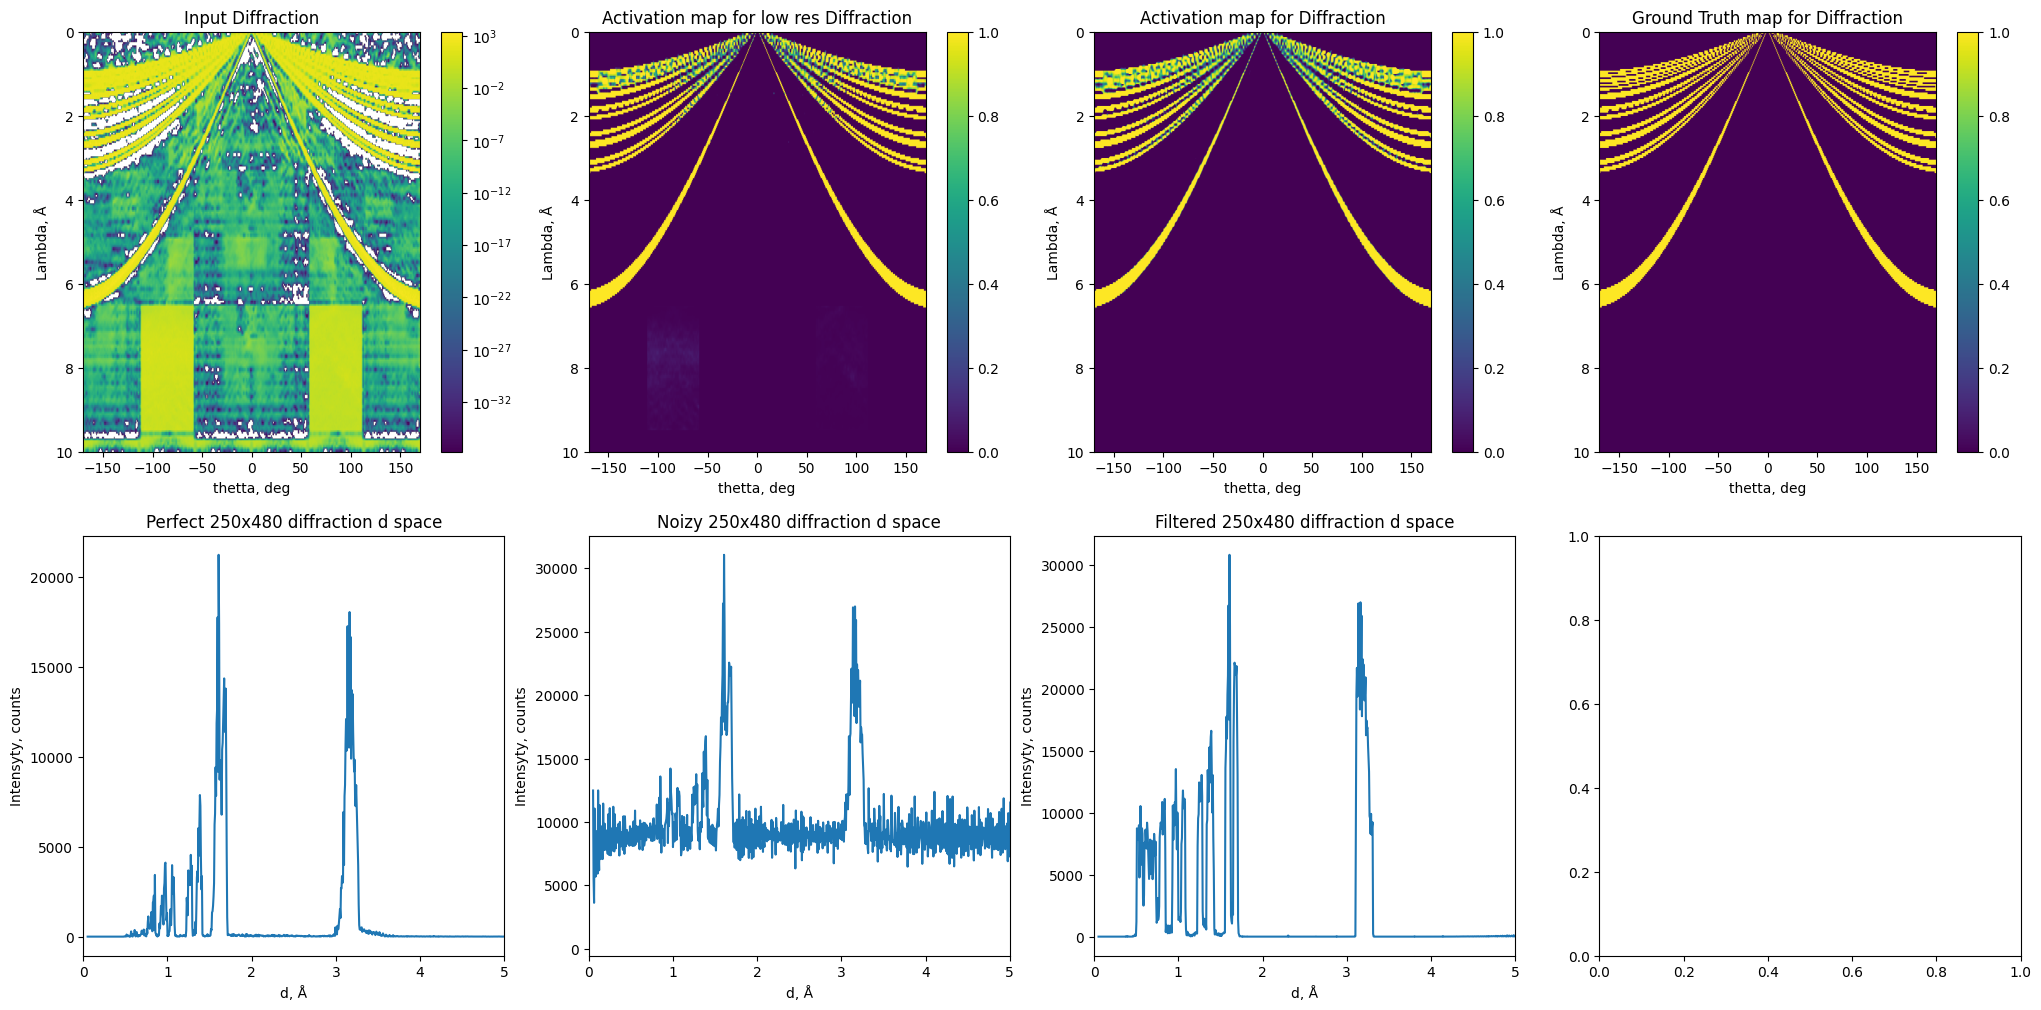

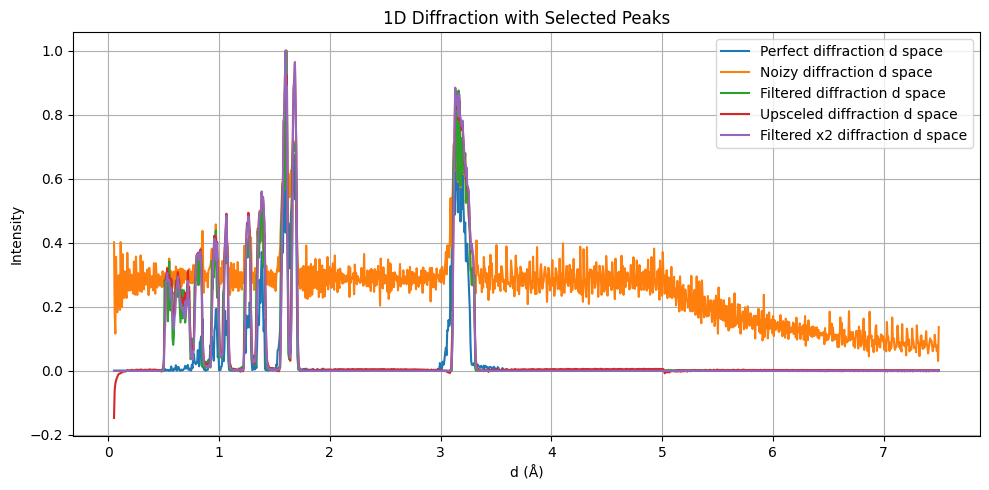

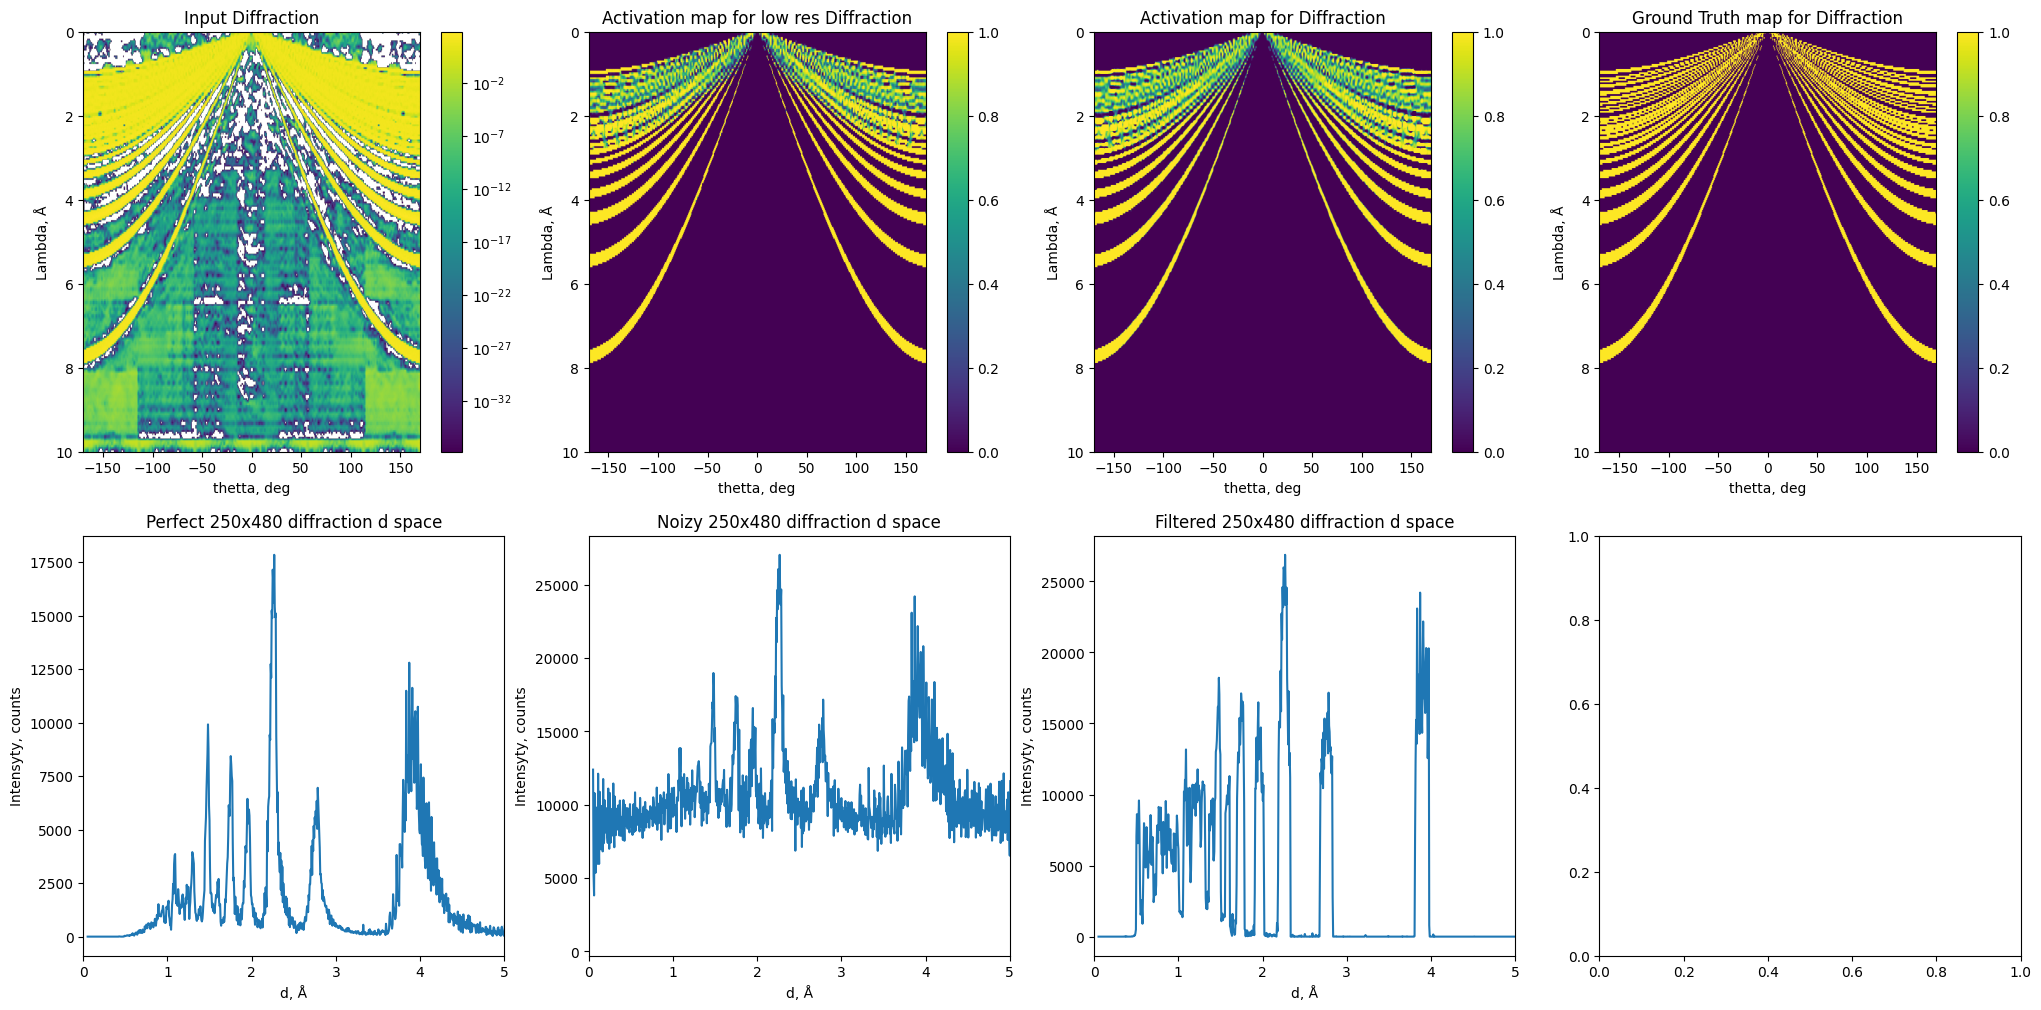

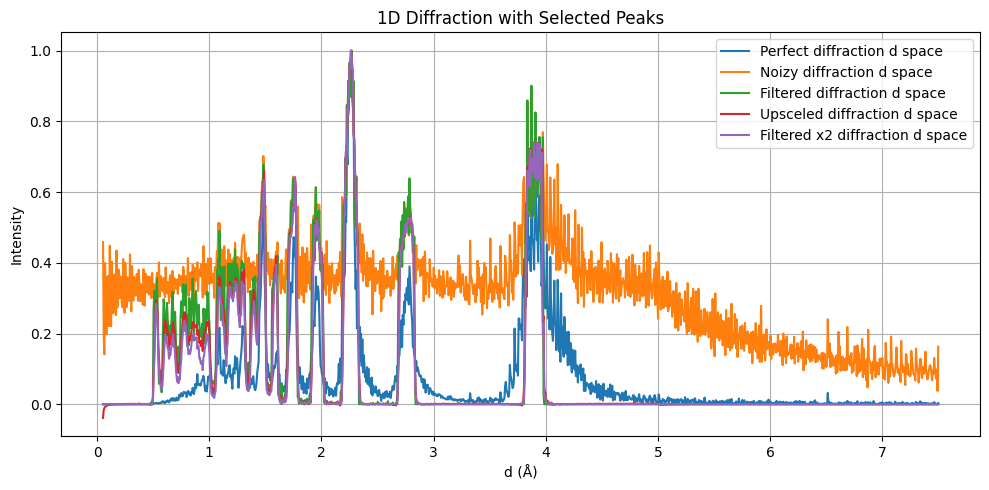

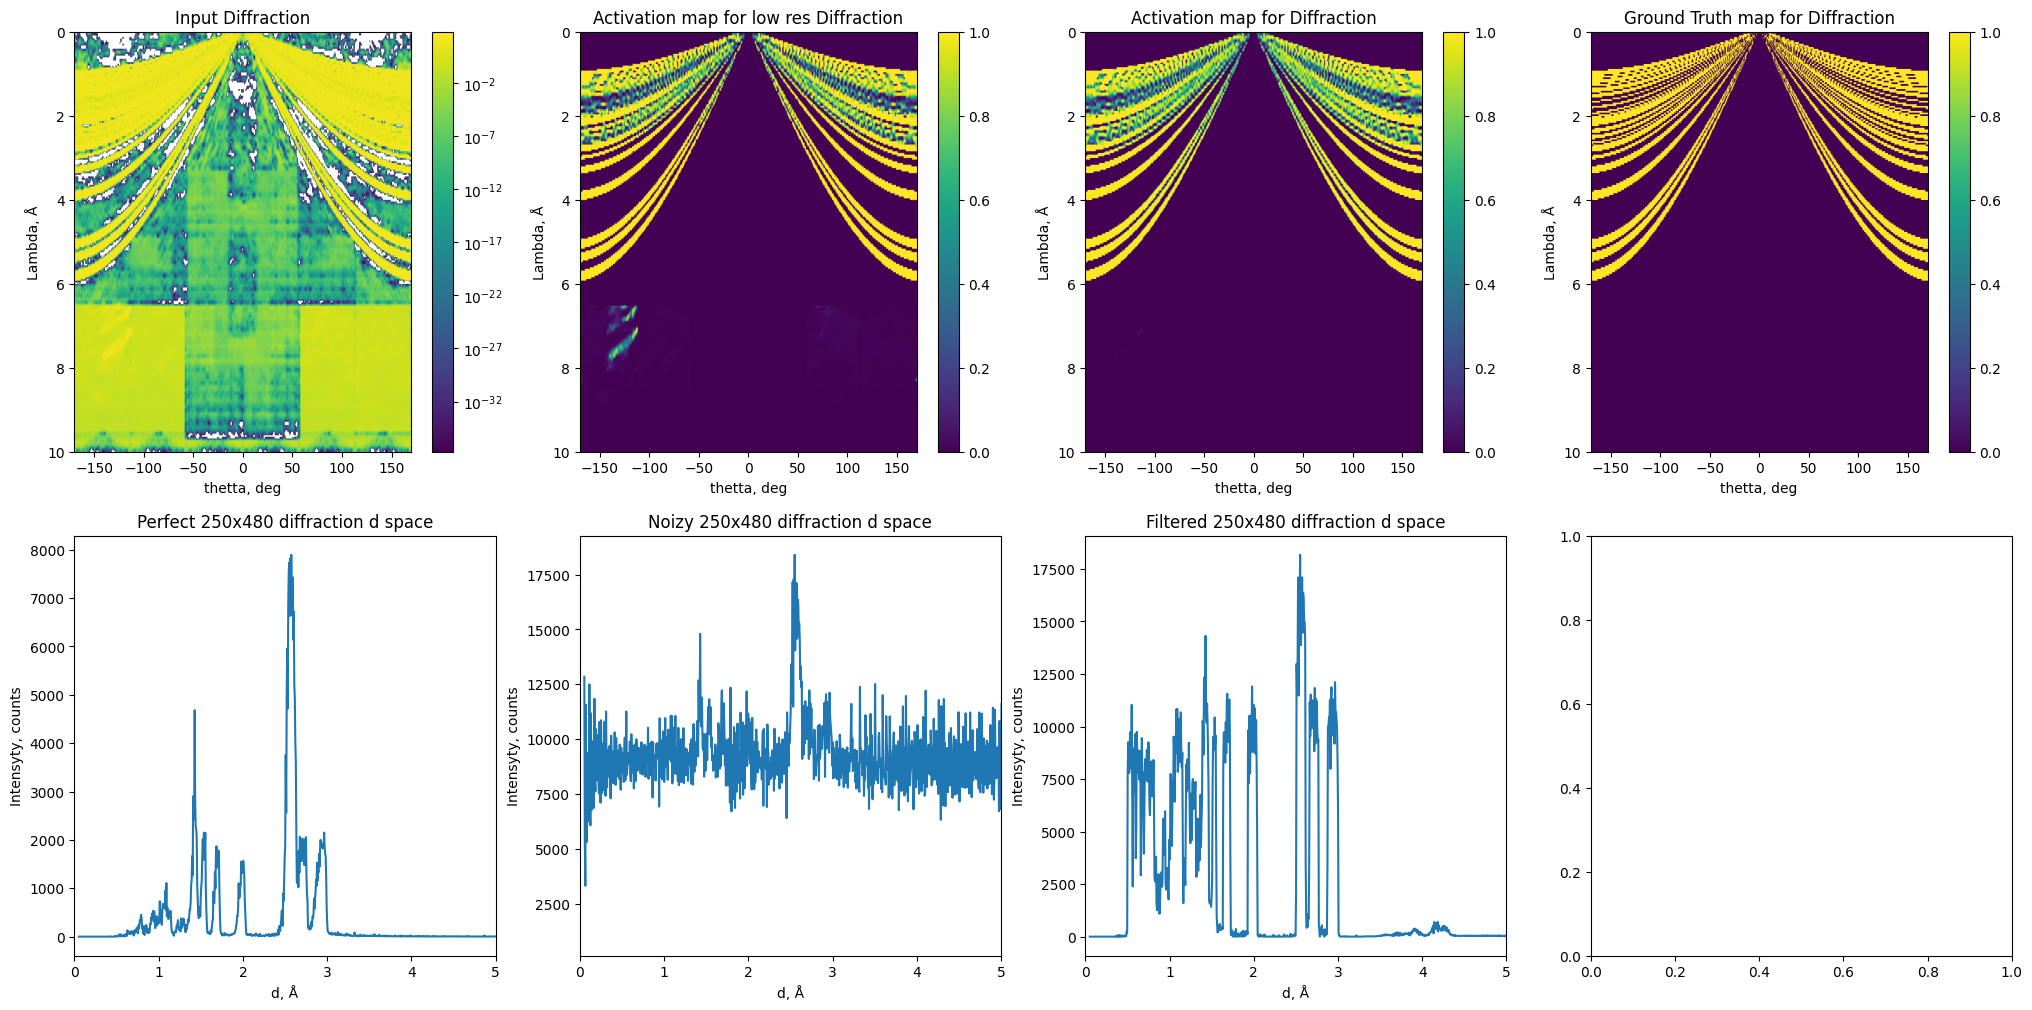

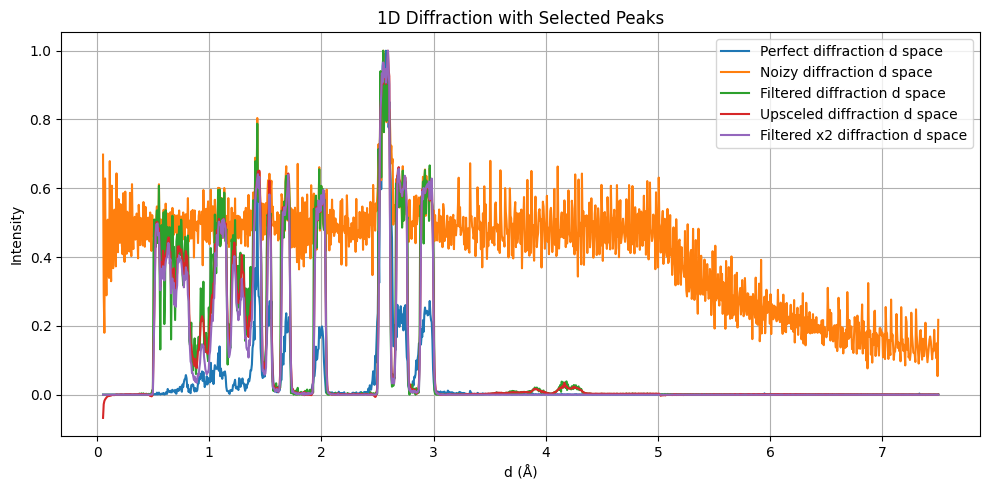

In [51]:
fixed_centers = np.linspace(0.05318052, 7.49710258, 1241)

qw = Qwrapper(
    theta_range=(-170, 170),
    L_range=(0.1, 10),
    fixed_centers=fixed_centers,
    device = "cpu"
)

loss_fn_segmentator = CombinedLoss(w_bce=1.0, w_dice=1.0)


model.eval()

with torch.no_grad():  # <--- ДОБАВИТЬ ЭТО
    for batch_idx, (images, masks) in enumerate(test_loader):

        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        out1 = qw.tensor_to_d(images)

        mu = 100
        sigma = 0.2*mu
        
        # Создаем шум на том же устройстве
        noise = torch.randn_like(images, device=device) * sigma + mu
        images = images + noise

        out2 = qw.tensor_to_d(images)

        with torch.cuda.amp.autocast():
             # ===== ODD BATCH =====
            seg, skips_seg = model.segment_1(images)
            loss_low = loss_fn_segmentator(seg, masks)
            print(loss_low)

            # prepare data for SR
            seg = torch.sigmoid(seg)
            images = seg * images

            norm_hr, params_hr = normalize_piecewise(images)
            # SR @ full scale
            sr_out, skips_sr = model.upscale(norm_hr.to(device), skips_seg)
            denorm_pred = denormalize_piecewise(sr_out, params_hr)

            # segmentation @ 2H
            seg_high, _ = model.segment_2(denorm_pred, skips_sr)

            masks = masks.float()  # Конвертируем в float
            masks = upsample_binary_mask_factor(masks)
            masks = masks.long()  # Возвращаем в long если нужно
            loss_high = loss_fn_segmentator(seg_high, masks)
            seg_high = torch.sigmoid(seg_high)
            print(loss_high)

        result = denorm_pred * seg_high
        out3 = qw.tensor_to_d(images)
        out4 = qw.tensor_to_d(denorm_pred)
        out5 = qw.tensor_to_d(result)

        for i, (diffraction, activation_map_lr, activation_map_hr,  mask) in enumerate(zip(images, seg, seg_high, masks)):

            # Создаем фигуру и оси
            fig, axes = plt.subplots(2, 4, figsize=(25, 12))
            ax1, ax2, ax3, ax4 = axes[0]  # Первая строка осей
            ax5, ax6, ax7, ax8 = axes[1]  # Вторая строка осей

            # Первый график
            im1 = ax1.imshow(diffraction[0].cpu().numpy(), cmap='viridis', aspect='auto', norm='log', extent=(-170, 170, 10, 0))
            ax1.set_title('Input Diffraction')
            ax1.set_xlabel('thetta, deg')
            ax1.set_ylabel('Lambda, Å')
            plt.colorbar(im1)

            ax5.plot(out1[i]["d"], out1[i]["I"])
            ax5.set_xlim(0, 5)
            #ax4.set_yscale('log')
            ax5.set_title(f"Perfect 250x480 diffraction d space")
            ax5.set_xlabel('d, Å')
            ax5.set_ylabel('Intensyty, counts')

            # Первый график
            im2 = ax2.imshow(activation_map_lr[0].cpu().numpy(), cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
            ax2.set_title('Activation map for low res Diffraction')
            ax2.set_xlabel('thetta, deg')
            ax2.set_ylabel('Lambda, Å')
            plt.colorbar(im2)

            ax6.plot(out2[i]["d"], out2[i]["I"])
            ax6.set_xlim(0, 5)
            #ax4.set_yscale('log')
            ax6.set_title(f"Noizy 250x480 diffraction d space")
            ax6.set_xlabel('d, Å')
            ax6.set_ylabel('Intensyty, counts')

            # Первый график
            im3 = ax3.imshow(activation_map_hr[0].cpu().numpy(), cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
            ax3.set_title('Activation map for Diffraction')
            ax3.set_xlabel('thetta, deg')
            ax3.set_ylabel('Lambda, Å')
            plt.colorbar(im3)

            # Первый график
            im4 = ax4.imshow(mask[0].cpu().numpy(), cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
            ax4.set_title('Ground Truth map for Diffraction')
            ax4.set_xlabel('thetta, deg')
            ax4.set_ylabel('Lambda, Å')
            plt.colorbar(im4)

            ax7.plot(out3[i]["d"], out3[i]["I"])
            ax7.set_xlim(0, 5)
            #ax4.set_yscale('log')
            ax7.set_title(f"Filtered 250x480 diffraction d space")
            ax7.set_xlabel('d, Å')
            ax7.set_ylabel('Intensyty, counts')

            plt.show()

            # Plot overall diffraction pattern
            plt.figure(figsize=(10, 5))
            plt.plot(out1[i]["d"], out1[i]["I"] / max(out1[i]["I"]), label='Perfect diffraction d space')
            plt.plot(out2[i]["d"], out2[i]["I"] / max(out2[i]["I"]), label='Noizy diffraction d space')
            plt.plot(out3[i]["d"], out3[i]["I"] / max(out3[i]["I"]), label='Filtered diffraction d space')
            plt.plot(out4[i]["d"], out4[i]["I"] / max(out4[i]["I"]), label='Upsceled diffraction d space')
            plt.plot(out5[i]["d"], out5[i]["I"] / max(out5[i]["I"]), label='Filtered x2 diffraction d space')
            plt.xlabel("d (Å)")
            plt.ylabel("Intensity")
            plt.title("1D Diffraction with Selected Peaks")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        break

In [ ]:
# допустим, твоя текущая модель называется vae
save_path = "../models/SwinWNet_diffraction.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Модель сохранена в {save_path}")

✅ Модель сохранена в models/SwinWNet_diffraction.pth


In [ ]:
from SwinUNet import SwinWNet

model = SwinWNet(patch_size=2, in_chans=1, embed_dim=48, depths=[2, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=5, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.).to(device)

model.load_state_dict(torch.load('../models/SwinWNet_diffraction.pth', map_location=device))

<All keys matched successfully>

In [17]:
import torch

def binarize_prediction(pred_probs, threshold=0.5):
    """
    pred_probs: torch.Tensor [B,1,H,W], float in [0,1]
    """
    return (pred_probs >= threshold).to(torch.uint8)

def confusion_matrix_binary(pred_bin, gt_bin):
    """
    pred_bin, gt_bin: [B,1,H,W], uint8 {0,1}
    """
    pred = pred_bin.view(-1)
    gt   = gt_bin.view(-1)

    TP = torch.sum((pred == 1) & (gt == 1)).float()
    TN = torch.sum((pred == 0) & (gt == 0)).float()
    FP = torch.sum((pred == 1) & (gt == 0)).float()
    FN = torch.sum((pred == 0) & (gt == 1)).float()

    return TP, TN, FP, FN

def pixel_accuracy(TP, TN, FP, FN, eps=1e-8):
    return (TP + TN) / (TP + TN + FP + FN + eps)

def iou_score(TP, FP, FN, eps=1e-8):
    return TP / (TP + FP + FN + eps)

def dice_score(TP, FP, FN, eps=1e-8):
    return (2 * TP) / (2 * TP + FP + FN + eps)

def precision_score(TP, FP, eps=1e-8):
    return TP / (TP + FP + eps)

def recall_score(TP, FN, eps=1e-8):
    return TP / (TP + FN + eps)

In [18]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.ndimage import binary_erosion

def extract_boundary(mask):
    """
    mask: [H,W] binary numpy array
    """
    eroded = binary_erosion(mask)
    boundary = mask ^ eroded
    return np.argwhere(boundary)

def compute_all_metrics(pred_probs, gt_mask, threshold=0.5):
    pred_bin = binarize_prediction(pred_probs, threshold)
    gt_bin   = gt_mask.to(torch.uint8)

    TP, TN, FP, FN = confusion_matrix_binary(pred_bin, gt_bin)

    metrics = {
        "PixelAccuracy": pixel_accuracy(TP, TN, FP, FN).item(),
        "IoU": iou_score(TP, FP, FN).item(),
        "Dice": dice_score(TP, FP, FN).item(),
        "Precision": precision_score(TP, FP).item(),
        "Recall": recall_score(TP, FN).item(),
    }
    
    return metrics


In [54]:
# Validation
model.eval()
metrics_25 = []
metrics_50 = []
metrics_75 = []
num_val_iterations = 5
with torch.no_grad():
    for _ in range(num_val_iterations):
        for images, masks in tqdm(test_loader):
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            # mu = random.randint(50, 200)
            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(images, device=device) * sigma + mu
            images = images + noise

            with torch.cuda.amp.autocast():
                # ===== ODD BATCH =====
                seg, skips_seg = model.segment_1(images)
                loss_low = loss_fn_segmentator(seg, masks)

                # prepare data for SR
                seg = torch.sigmoid(seg)
                images = seg * images

                norm_hr, params_hr = normalize_piecewise(images)
                # SR @ full scale
                sr_out, skips_sr = model.upscale(norm_hr.to(device), skips_seg)
                denorm_pred = denormalize_piecewise(sr_out, params_hr)

                # segmentation @ 2H
                seg_high, _ = model.segment_2(denorm_pred, skips_sr)

                masks = masks.float()  # Конвертируем в float
                masks = upsample_binary_mask_factor(masks)
                masks = masks.long()  # Возвращаем в long если нужно
                loss_high = loss_fn_segmentator(seg_high, masks)
                seg_high = torch.sigmoid(seg_high)


            for i, (activation_map,  mask) in enumerate(zip(seg_high, masks)):

                activation_map = activation_map.unsqueeze(0)
                mask = mask.unsqueeze(0)

                metrics_25.append(compute_all_metrics(activation_map, mask, threshold=0.25))
                metrics_50.append(compute_all_metrics(activation_map, mask, threshold=0.5))
                metrics_75.append(compute_all_metrics(activation_map, mask, threshold=0.75))

100%|██████████| 80/80 [00:18<00:00,  4.25it/s]


In [ ]:
import json

with open("../results/SwinWnet_segmentation_metrics.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "metrics_25": metrics_25,
            "metrics_50": metrics_50,
            "metrics_75": metrics_75
        },
        f,
        indent=4,
        ensure_ascii=False
    )


In [ ]:
with open("../results/SwinWnet_segmentation_metrics.json", "r", encoding="utf-8") as f:
    data = json.load(f)

metrics_25 = data["metrics_25"]
metrics_50 = data["metrics_50"]
metrics_75 = data["metrics_75"]


In [63]:
import numpy as np

def extract_metric(metrics_list, metric_name):
    return np.array([m[metric_name] for m in metrics_list])

metrics_names = ["PixelAccuracy", "IoU", "Dice", "Precision", "Recall"]

for metric_name in metrics_names:
    print(metric_name)
    arr_25 = extract_metric(metrics_25, metric_name)
    mean_25 = np.mean(arr_25)
    std_25 = np.std(arr_25)
    print(f'0.25 thrashold {metric_name}: mean: {mean_25}, std: {std_25}')

    arr_50 = extract_metric(metrics_50, metric_name)
    mean_50 = np.mean(arr_50)
    std_50 = np.std(arr_50)
    print(f'0.50 thrashold {metric_name}: mean: {mean_50}, std: {std_50}')

    arr_75 = extract_metric(metrics_75, metric_name)
    mean_75 = np.mean(arr_75)
    std_75 = np.std(arr_75)
    print(f'0.75 thrashold {metric_name}: mean: {mean_75}, std: {std_75}')

    print('-----------------------------------------------------------------------')

PixelAccuracy
0.25 thrashold PixelAccuracy: mean: 0.9607266713182131, std: 0.025849394824427135
0.50 thrashold PixelAccuracy: mean: 0.9647468523681164, std: 0.024349904141227976
0.75 thrashold PixelAccuracy: mean: 0.9620014603932698, std: 0.02523552803935066
-----------------------------------------------------------------------
IoU
0.25 thrashold IoU: mean: 0.7776432955265045, std: 0.06973469223589494
0.50 thrashold IoU: mean: 0.7874518775443236, std: 0.071357424483463
0.75 thrashold IoU: mean: 0.7549192852526904, std: 0.07746201425451807
-----------------------------------------------------------------------
Dice
0.25 thrashold Dice: mean: 0.8729490321377913, std: 0.050283647119769403
0.50 thrashold Dice: mean: 0.8790328172842662, std: 0.05171922542414162
0.75 thrashold Dice: mean: 0.8577231418341398, std: 0.05984885852952798
-----------------------------------------------------------------------
Precision
0.25 thrashold Precision: mean: 0.8022679747392734, std: 0.06023492438618517
0

In [20]:
import torch
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from tqdm import tqdm

# Инициализируем метрики
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)  # data_range=1.0 для диапазона [0, 1]
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Validation
model.eval()
PSNRs = []
SSIMs = []
peak_losses = []
num_val_iterations = 5
with torch.no_grad():
    for _ in range(num_val_iterations):
        for hr, _ in tqdm(test_loader):
            hr = hr.to(device)

            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(hr, device=device) * sigma + mu
            hr = hr + noise

            with torch.cuda.amp.autocast():
                # ===== ODD BATCH =====
                seg, skips_seg = model.segment_1(hr)

                # prepare data for SR
                seg = torch.sigmoid(seg)
                hr = seg * hr

                lr = F.interpolate(
                    hr, 
                    scale_factor=0.5, 
                    mode='bilinear', 
                    align_corners=False
                )  # размер: [32, 1, 125, 240]

                norm_lr, params_lr = normalize_piecewise(lr)
                denorm_lr = denormalize_piecewise(norm_lr, params_lr)

                norm_hr, params_hr = normalize_piecewise(hr)
                denorm_hr = denormalize_piecewise(norm_hr, params_hr)

                # SR @ full scale
                sr_out, _ = model.upscale(norm_lr.to(device), skips_seg)
                denorm_pred = denormalize_piecewise(sr_out, params_hr)

                for i, (gt_normed_diffraction, pred_normed_diffraction) in enumerate(zip(norm_hr, sr_out)):

                    gt_normed_diffraction = gt_normed_diffraction.unsqueeze(0).to(device)
                    pred_normed_diffraction = pred_normed_diffraction.unsqueeze(0).to(device)

                    # Вычисляем метрики
                    psnr_value = psnr_metric(gt_normed_diffraction, pred_normed_diffraction) # img_pred, img_gt
                    ssim_value = ssim_metric(gt_normed_diffraction, pred_normed_diffraction)

                    PSNRs.append(psnr_value.cpu().item())
                    SSIMs.append(ssim_value.cpu().item())

                    loss_peaks = pipe(
                        batch_pred_2d=denorm_pred[i].unsqueeze(0),     # предсказанная 2D дифракция
                        batch_true_2d=lr[i].unsqueeze(0),     # ground-truth 2D
                        peak_params_pred={"scale": True},
                        peak_params_true={"scale": False},
                        tol=0.05
                    )

                    peak_losses.append(loss_peaks.cpu().item())

100%|██████████| 80/80 [00:04<00:00, 17.86it/s]


In [ ]:
import json

with open("../results/SwinWnet_upscaling_metrics.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "PSNRs": PSNRs,
            "SSIMs": SSIMs,
            "peak_losses": peak_losses
        },
        f,
        indent=4,
        ensure_ascii=False
    )


In [ ]:
with open("../results/SwinWnet_upscaling_metrics.json", "r", encoding="utf-8") as f:
    data = json.load(f)

PSNRs = data["PSNRs"]
SSIMs = data["SSIMs"]
peak_losses = data["peak_losses"]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Предполагаем, что у вас уже есть массивы:
# PSNRs, SSIMs, peak_losses - списки или numpy массивы

# 1. Расчет среднего и стандартного отклонения
def calculate_statistics(data, metric_name):
    """Вычисляет среднее и стандартное отклонение"""
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)  # ddof=1 для несмещенной оценки
    
    print(f"{metric_name}:")
    print(f"  Среднее: {mean_val:.4f}")
    print(f"  СКО: {std_val:.4f}")
    print(f"  Минимум: {np.min(data):.4f}")
    print(f"  Максимум: {np.max(data):.4f}")
    print(f"  Количество образцов: {len(data)}")
    print("-" * 40)
    
    return mean_val, std_val

# Вычисляем статистики для всех метрик
psnr_mean, psnr_std = calculate_statistics(PSNRs, "PSNR (dB)")
ssim_mean, ssim_std = calculate_statistics(SSIMs, "SSIM")
peak_mean, peak_std = calculate_statistics(peak_losses, "Peak Loss")

PSNR (dB):
  Среднее: 31.2250
  СКО: 3.8624
  Минимум: 20.0199
  Максимум: 40.8078
  Количество образцов: 1200
----------------------------------------
SSIM:
  Среднее: 0.9338
  СКО: 0.0236
  Минимум: 0.8311
  Максимум: 0.9751
  Количество образцов: 1200
----------------------------------------
Peak Loss:
  Среднее: 1.2600
  СКО: 1.5861
  Минимум: 0.0000
  Максимум: 10.4789
  Количество образцов: 1200
----------------------------------------


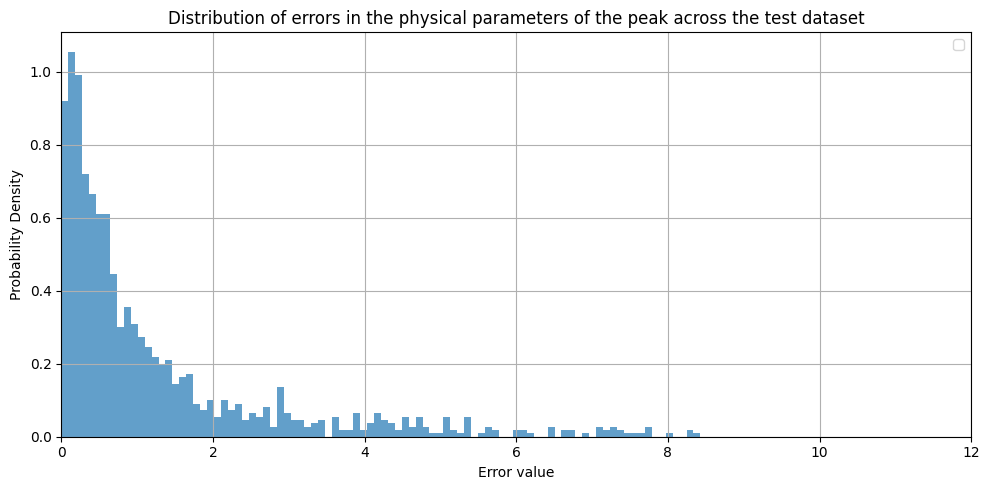

In [59]:
plt.figure(figsize=(10, 5))
plt.hist(peak_losses, alpha=0.7, bins=300, density=True)
plt.xlim(0,12)
plt.xlabel("Error value")
plt.ylabel("Probability Density")
plt.title("Distribution of errors in the physical parameters of the peak across the test dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()